# **Importing Libraries:**

In [ ]:
# For Preprocessing Module
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta
from dateutil.parser import parse
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import pandas as pd

from langdetect import detect
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
contraction_dict = {"ain't": "is not","aint":"is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not","didnt": "did not",  "doesn't": "does not", "doesnt": "does not","don't": "do not",
                    "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                    "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "isnt": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would",
                    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have","today's": "today is","tomorrow's":"tomorrow is", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have","&amp;":"and","&lt;":"<","&gt;":">","&le;":"=<","&ge;":">="}
stop_words=set(stopwords.words('english'))

In [ ]:
# For Filtering Module
from pyLSHash import LSHash
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse import issparse

In [ ]:
# For Clustering
from umap import UMAP
# Using DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import itertools
# Using HDBSCAN
from hdbscan import HDBSCAN

In [ ]:
# For Sentiment Analysis
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax

In [ ]:
# For Event Summarization
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# For Related Topics
from transformers import TFAutoModelForSequenceClassification
from scipy.special import expit

In [ ]:
# More stuff
import subprocess
import json
import os
from yellowbrick.datasets import load_hobbies
from yellowbrick.text import UMAPVisualizer
from mpl_toolkits.mplot3d import Axes3D

from mlxtend.frequent_patterns import fpgrowth
from collections import Counter

# **Preprocessing Module:**

In [ ]:
def categorize_tweets(df, window_size='4H'):
    if 'H' in window_size:
        time_unit = 'h'
    elif 'M' in window_size:
        time_unit = 'min'
    elif 'S' in window_size:
        time_unit = 's'
    else:
        raise ValueError("Invalid window size format. Use '2H' for hours or '2M' for minutes.")

    time_value = int(window_size[:-1])
    if(time_unit=='h'):
        window_length = pd.Timedelta(hours = time_value)
    elif(time_unit=='min'):
        window_length = pd.Timedelta(minutes = time_value)
    else:
        window_length = pd.Timedelta(seconds = time_value)
    categorized = OrderedDict()
    categorized_indexes = OrderedDict()

    # df['Date'] = pd.to_datetime(df['TweetDate'])
    df['Date'] = pd.to_datetime(df['TweetDate'], format='%a %b %d %H:%M:%S %z %Y')
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    # print(window_length)

    current_time = df['Date'].min().floor(time_unit)
    last_time = df['Date'].max().floor(time_unit)
    # print(current_time)
    # print(last_time)
    df['Group'] = None

    while current_time <= last_time:
        categorized[current_time] = []
        categorized_indexes[current_time] = []
        current_time += window_length

    for index, row in df.iterrows():
        tweet_time = row['Date'].floor(time_unit)
        window_start = tweet_time - (tweet_time - current_time) % window_length
        df.loc[index, 'Group'] = window_start
        categorized[window_start].append(row['Text'])
        categorized_indexes[window_start].append(index)
        # if (index + 1) % 5000 == 0:
        #     print(f"Finished grouping {index + 1} rows")

    return categorized, categorized_indexes

tt = TweetTokenizer()

def removestopwords(line):
    words=line.split(" ")
    wordslist=[]
    if "off" in stop_words:
        stop_words.remove("off")
    while "rt" in words:
        words.remove("rt")
    while "sl" in words:
        words.remove("sl")
    for word in words:
            if not word in stop_words:
                wordslist.append(word)
    return ' '.join(wordslist)

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize(tweet):
    nltk_tagged = nltk.pos_tag(tt.tokenize(tweet))
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)

    res_words = []
    for word, tag in wn_tagged:
        if tag is None:
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))

    return ' '.join(res_words)

def removeUnnecessaryWords(x):
    words=x.split(" ")
    result = []
    for word in words:
        if not len(word) < 2:
            result.append(word)

    if len(result)>1:
        return ' '.join(result)
    else:
        return ""
def remove_duplicates(tweet):
    words = tweet.split(" ")
    unique_words = []
    seen = set()
    for word in words:
        if word not in seen:
            unique_words.append(word)
            seen.add(word)
    return ' '.join(unique_words)
def remove_only_hashtags_tweets(tweet):
    temp = re.sub(r'#\w+', '', tweet)
    temp = re.sub(r'@\w+', '', temp)
    temp=re.sub(r' +',' ',temp)
    temp=re.sub(r' +[a-zA-Z] +',' ',temp)
    temp=temp.strip()
    if temp == "":
        return temp
    words=temp.split(" ")
    if(len(words) > 1):
        return tweet
    else:
        return ""

def remove_bad_tweets(tweet):
    bad_words =["ãusgsã","sismos","sismo","fck","stupidity","disgusting","scum","di","ke-4","gooooolllllll","dowd",
                "yikes","nooooooooooooo","nooooo","noooo","nooooooooo","elf","cantwell",
                "debate","booooooooooooooooooooo","ummm","ummmm","stupidville","lolz",
                "sexenio","stupid","dumbest","idiot","stupidtweets","dumb","pleasepleaseplease","bahh"
                "cantwell","cordova","adak",
                "aniak","bethel","hoonah","homer" ,"craig" ,
                "wtf","gop","dtn","tou","woul","sup","supe","expe",
                "dog","aaaawwwww","aaaawwww","awwwww","awwwwwwwww","awwwwh",
                "crap","rtâ","ryâ","welpâ","lame",
                "fuck", "fucked","fucking","fuuuucckk","shittttt","sucks","suck",
                "fucking","lmao","lol","dick","ass","nigga","bitch","bitches","shit",
                "shitheads","fuckin"]

    words = tweet.split(" ")
    for word in words:
        if word in bad_words:
            return ""
    return tweet
def preprocess(tweets):
    cleaned_tweets = []
    count = 0
    for tweet in tweets :
        tweet = tweet.lower()
        tweet=replace_contractions(tweet)
        # Remove URLs
        tweet = re.sub(r'(via:)? +https?:\/\/.*','', tweet)
        tweet = re.sub(r'https?://\S+', '', tweet)
        # Remove user mentions
        tweet = re.sub(r'@\w+', '', tweet)
#         tweet = re.sub(r'#\w+', '', tweet)
        # Remove punctuation except hashtags
#         tweet = re.sub(r'[^\w\s#]', ' ', tweet)
        # Remove punctuation except hashtags , - , @
        # tweet = re.sub(r'[^\w\s#@%-]', '', tweet)
        tweet = tweet.replace('\n', ' ')
        tweet = re.sub(r'(?<!\d)-|-(?!\d)', ' ', tweet)
        tweet = re.sub(r'[^\w\s#@%-]', ' ', tweet)
#         tweet = re.sub(r'[^\w\s]', ' ', tweet)
        # Remove special characters
#         tweet=re.sub(r'[:-?;&)(!"*%_+$~/\[\]]',' ',tweet)
        tweet=removestopwords(tweet)
        # tweet=lemmatize(tweet)
        tweet=re.sub(r' +',' ',tweet)
        tweet=re.sub(r' +[a-zA-Z] +',' ',tweet)
        tweet=tweet.strip()
        tweet =remove_duplicates(tweet)
        tweet =remove_bad_tweets(tweet)
        tweet=removeUnnecessaryWords(tweet)
        tweet =remove_only_hashtags_tweets(tweet)
        cleaned_tweets.append(tweet)
        count+=1
        # if count % 5000 == 0:
        #     print(f"Preprocessed {count} rows")
    # tokens = tweet.split()
    return cleaned_tweets

def preprocess_dataframe(df) :
    # df.drop_duplicates(subset=["TweetText"],inplace=True)
    # df.drop(df[df['TweetText'].str.startswith('RT @')].index, inplace=True)
    df.replace({'TweetText': {'': np.nan}}, inplace=True)
    df.replace({'TweetDate': {'': np.nan}}, inplace=True)
    df.dropna(subset=['TweetDate', 'TweetText'], inplace=True)
    df['Text'] = preprocess(df['TweetText'])
    # df['Text'].replace('', np.nan, inplace=True)
    df.replace({'Text': {'': np.nan}}, inplace=True)
    df.dropna(subset=['Text'], inplace=True)
#     df.drop_duplicates(subset=["Text"],inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"Number of Rows After Preprocessing: {len(df)}")
    return df

def compute_tfidf_matrix(tweets):
    vectorizer = TfidfVectorizer(preprocessor=None, tokenizer=None, token_pattern=r'[^ ()]+'  )
    tfidf_matrix = vectorizer.fit_transform(tweets)
    return tfidf_matrix, vectorizer.get_feature_names_out()

# def generate_ri_matrix(feature_names, dimensions=1000):
#     ri_matrix = {}
#     for feature in feature_names:
#         ri_matrix[feature] = np.random.randint(0, 2, dimensions)
#     return ri_matrix
# def preprocess_dict(dict) :
#     processed_dict = {key: preprocess(tweet) for key, tweet in dict.items()}
#     return processed_dict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Filtering Module**

In [ ]:
def cosine_sim(x, y):
    if(x.shape[0]!=y.shape[0]):
        # print("shape unmatched ",y)
        return 0
    else:
        return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0]
def euclidean_dist_square(x, y):
    if(x.shape[0]!=y.shape[0]):
        # print("shape unmatched ",y)
        diff = np.array(x) - x
    else:
        diff = np.array(x) - y
    return np.dot(diff, diff)

def filtering_module(df,tweets,tweets_indexes,tfidf_matrix , hash_size = 10, num_hashtables = 6 , num_groups = 3):

    # reduced_matrix = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine' ,random_state=42).fit_transform(tfidf_matrix)
    reduced_matrix=tfidf_matrix
    sparse = issparse(reduced_matrix)
    input_dim = reduced_matrix.shape[1]
    # lsh = LSHash(hash_size, input_dim, num_hashtables)
    # lsh.clear_storage()
    lsh = LSHash(hash_size, input_dim, num_hashtables)
    count = 0
    df['Type'] = None
    # Type = np.full(df.shape[0], 'Not Unique', dtype='S9')
    group = 0
    hashedGroups = 0
    collided_tweets_sizes = []
    # similarity_array =[]
    for index, (key, value) in enumerate(tweets_indexes.items()):
        if(index < num_groups):
            # if(len(value)==0):
            #     num_groups = num_groups + 1
            for val in value:
                if(sparse):
                    lsh.index(reduced_matrix[val].toarray()[0], extra_data = val)
                else:
                    lsh.index(reduced_matrix[val], extra_data = val)
                df.loc[val, 'Type'] = 'Not Unique'
                hashedGroups+=1
                count+=1
                # if count % 5000 == 0:
                #     print(f"Hashed {count} rows")
            group+=1
        else:
            for val in value:
                current_tweet_tfidf = tfidf_matrix[val]
                # print(current_tweet_tfidf)
                if(sparse):
                    collision_set = lsh.query(reduced_matrix[val].toarray()[0], num_results=None )
                else:
                    collision_set = lsh.query(reduced_matrix[val], num_results=None )
                count+=1
                collided_tweets_sizes.append(len(collision_set))
                # similarity_values = []
                similarity_value = 0;

                for (collided_tweet, _) in collision_set:
                    collided_tweet_tfidf = tfidf_matrix[collided_tweet[1]]
                    if(sparse):
                        similarity = cosine_similarity(current_tweet_tfidf, collided_tweet_tfidf)[0][0]
                    else:
                        similarity = cosine_similarity(current_tweet_tfidf.reshape(1, -1), collided_tweet_tfidf.reshape(1, -1))[0][0]
                    similarity_value = max(similarity_value , similarity)
                    # break
                    # similarity_values.append(similarity)
                # similarity_array.append(similarity_values)
                if similarity_value >= 0.1:
                    df.loc[val, 'Type'] = 'Not Unique'
                    # lsh.index(current_tweet_tfidf.toarray()[0], extra_data = val)
                else:
                    df.loc[val, 'Type'] = 'Unique'

                # if count % 5000 == 0:
                #     print(f"Filtered {count} rows")

            # group+=1
    lsh.clear_storage()
    print('Size of Hashed groups',hashedGroups)
    # print(count)
    print(group)
    # print(similarity_array)
    return collided_tweets_sizes


# def remove_unique_tweets(df,tweets,tweets_indexes):
#     rows_to_delete = []
#     for i, row in df.iterrows():
#         if row['Type'] == 'Unique':
#             group = row['Group']
#             found = tweets_indexes[group].index(i)
#             del tweets_indexes[group][found]
#             del tweets[group][found]
#             rows_to_delete.append(i)
#     # df.drop(rows_to_delete, inplace=True)

def remove_unique_tweets(df,window_size='4H'):
    rows_to_delete = df[df['Type'] == 'Unique'].index
    df.drop(rows_to_delete, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return categorize_tweets(df, window_size)

def get_dictionary_size(dictionary):
    count =0
    for key , val in dictionary.items():
        count+=len(val)
    return count


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Clustering Module:**

In [ ]:
# DBSCAN Clustering
def DBSCAN_clustering(combinations , matrix):
    scores = []
    all_labels_list = []
    # reduced_matrix = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine' ,random_state=42).fit_transform(matrix)
    reduced_matrix = matrix
    for i ,(eps , num_samples) in enumerate(combinations):
        dbscan_cluster_model = DBSCAN(eps = eps, min_samples = num_samples).fit(reduced_matrix)
        labels = dbscan_cluster_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -=1
        if(num_clusters < 2):
            scores.append(-10)
            all_labels_list.append('nothing')
            c = (eps, num_samples)
            print(f"Combination {c} on iteration {i+1} of {len(combinations)} has {num_clusters} clusters. Moving on")
            continue
        scores.append(silhouette_score(reduced_matrix,labels))
        # scores.append(15)

        all_labels_list.append(labels)
        print(f"iteration: {i+1}, Silhouette Score: {scores[-1]}, Number of Clusters: {num_clusters}")
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]
    return {'best_epsilon':best_parameters[0],
            'best_min_samples' : best_parameters[1],
            'best_labels' : best_labels,
            'best_score' : best_score}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# HDBSCAN Clustering
def HDBSCAN_clustering(min_cluster_size_array, matrix):
    scores = []
    all_labels_list = []
    # reduced_matrix = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine' ,random_state=42).fit_transform(matrix)
    reduced_matrix = matrix
    # print(reduced_matrix.shape)
    for i, min_cluster_size in enumerate(min_cluster_size_array):
        # hdbscan_cluster_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True).fit(reduced_matrix.toarray())
        if issparse(reduced_matrix) :
            hdbscan_cluster_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom').fit(reduced_matrix.toarray())
        else:
            hdbscan_cluster_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom').fit(reduced_matrix)
        labels = hdbscan_cluster_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -=1
        if num_clusters < 1:
            scores.append(-10)
            all_labels_list.append('nothing')
            # print(f"Min cluster size {min_cluster_size} on iteration {i+1} of {len(min_cluster_size_array)} has {num_clusters} clusters. Moving on")
            continue
        scores.append(silhouette_score(reduced_matrix, labels))
        all_labels_list.append(labels)
        # print(f"Iteration: {i+1} , Silhouette Score: {scores[-1]}, Number of Clusters: {num_clusters}")
    best_index = np.argmax(scores)
    best_parameters = min_cluster_size_array[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]
    return {
        'best_min_cluster_size': best_parameters,
        'best_labels': best_labels,
        'best_score': best_score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# from sklearn.cluster import OPTICS

# def OPTICS_clustering(combinations, matrix):
#     scores = []
#     all_labels_list = []
#     reduced_matrix = matrix

#     for i, (eps, min_samples) in enumerate(combinations):
#         optics_cluster_model = OPTICS(min_samples=min_samples, eps=eps).fit(reduced_matrix.toarray())
#         labels = optics_cluster_model.labels_
#         labels_set = set(labels)
#         num_clusters = len(labels_set) - (1 if -1 in labels_set else 0)

#         if num_clusters < 2:
#             scores.append(-10)
#             all_labels_list.append('nothing')
#             continue

#         scores.append(15)
#         # scores.append(scores.append(silhouette_score(reduced_matrix,labels)))

#         all_labels_list.append(labels)

#     best_index = np.argmax(scores)
#     best_parameters = combinations[best_index]
#     best_labels = all_labels_list[best_index]
#     best_score = scores[best_index]

#     return {'best_epsilon': best_parameters[0],
#             'best_min_samples': best_parameters[1],
#             'best_labels': best_labels,
#             'best_score': best_score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_clustering(matrix, minRange = 5 , maxRange = 200 ,step=5):
    silhouette_scores = []
    all_labels_list = []
    num_clusters =[]
    range_clusters = range(minRange, maxRange, step)
    for n_clusters in range_clusters:
        kmeans = KMeans(n_clusters=n_clusters,n_init="auto" , random_state=42)
        cluster_labels = kmeans.fit_predict(matrix)
        silhouette_avg = silhouette_score(matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        all_labels_list.append(cluster_labels)
        num_clusters.append(n_clusters)
    best_labels = all_labels_list[np.argmax(silhouette_scores)]
    best_index = np.argmax(silhouette_scores)
    best_parameters = num_clusters[best_index]
    print("Cluster labels:", best_parameters)
    best_labels = all_labels_list[best_index]
    best_score = silhouette_scores[best_index]

    return {'best_numClusters': best_parameters,
            'best_labels': best_labels,
            'best_score': best_score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Sentiment Analysis Module:**

In [ ]:
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)

def sentiment_analysis(text):
    encoded_input = sentiment_tokenizer(text, return_tensors='pt')
    # print(encoded_input)
    output = sentiment_model(**encoded_input)
    # print(output)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

# def analyze_clusters_sentiments(clusters):
#     cluster_sentiments = {}
#     for cluster_id, texts in clusters.items():
#         sentiments = [sentiment_analysis(text) for text in texts]
#         # Aggregate sentiments for the cluster
#         cluster_sentiments[cluster_id] = np.mean(sentiments, axis=0)
#     return cluster_sentiments

def analyze_cluster_sentiments(cluster):
    cluster_sentiments = []
    for text in cluster:
        # text = df.iloc[text_index]["Text"]
        # print(text)
        cluster_sentiments.append(sentiment_analysis(text))
    # print(cluster_sentiments)
    return np.mean(cluster_sentiments, axis=0)

def get_sentiment(sentiment):
    max_index = np.argmax(sentiment)
    categories = ['Negative', 'Neutral', 'Positive']
    return categories[max_index]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Related Topics Module:**

In [ ]:
topic_model_name = f"cardiffnlp/tweet-topic-latest-multi"
topic_tokenizer = AutoTokenizer.from_pretrained(topic_model_name)

topic_model = AutoModelForSequenceClassification.from_pretrained(topic_model_name)
topic_class_mapping = topic_model.config.id2label

def tweet_related_topics(tweet):
    tokens = topic_tokenizer(tweet, return_tensors='pt')
    output = topic_model(**tokens)
    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    return scores

def cluster_related_topics(cluster):
    cluster_scores = []

    for tweet in cluster:
        tweet_score= tweet_related_topics(tweet)
        cluster_scores.append(tweet_score)

    cluster_final_score = np.mean(cluster_scores, axis=0)
    cluster_predictions = (cluster_final_score >= 0.5) * 1
    cluster_topics = []

    for i in range(len(cluster_predictions)):
        if cluster_predictions[i]:
            cluster_topics.append(topic_class_mapping[i])

    return cluster_topics


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Event Summarization Module:**

In [ ]:
# def get_cluster_top_keywords( k , cluster ):
#     vec = CountVectorizer( preprocessor=None, tokenizer=None, token_pattern=r'[^ ()]+')
#     print(cluster)
#     matrix = vec.fit_transform(cluster)
#     feature_names = vec.get_feature_names_out()
#     print(feature_names)
#     # top_keywords = [feature_names[i] for i in np.argsort(-matrix.sum(axis=0))[0, :k]][0][0]
#     # top_keywords = feature_names[:k]
#     return feature_names
def get_cluster_top_keywords( k ,cluster):
    vec = TfidfVectorizer(preprocessor=None, tokenizer=None, token_pattern=r'[^ ()]+')
    matrix = vec.fit_transform(cluster)
    feature_names = np.array(vec.get_feature_names_out())
    frequencies = np.asarray(matrix.sum(axis=0)).ravel()
    sorted_indices = np.argsort(-frequencies)
    top_keywords = feature_names[sorted_indices]
    return top_keywords.tolist()

def get_representative_headline(k ,cluster):
    keywords = get_cluster_top_keywords( k , cluster )
    cluster_keywords = ' '.join(keywords)
    vec = TfidfVectorizer()
    cluster_tfidf_matrix = vec.fit_transform(cluster)
    cluster_keywords_vector = vec.transform([cluster_keywords])
    similarities = cosine_similarity(cluster_keywords_vector, cluster_tfidf_matrix)
    representative_idx = np.argmax(similarities[0])
    representative_headline = cluster[representative_idx]
    return representative_idx , keywords

def get_representative_tweet(keywords,cluster):
    cluster_text = ' '.join(keywords)
    vec = TfidfVectorizer()
    cluster_tfidf_matrix = vec.fit_transform(cluster)
    cluster_text_vector = vec.transform([cluster_text])
    similarities = cosine_similarity(cluster_text_vector, cluster_tfidf_matrix)
    representative_idx = np.argmax(similarities[0])
    representative_tweet = cluster[representative_idx]
    return representative_tweet


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Events Detection Module:**

In [ ]:
def get_tweets_entry_rate(clustering_type ,df , tweets_indexes , num_clusters ,window_size = '4H'):
    tweets_entry_rate = OrderedDict()
    clusters_tweets = OrderedDict()
    clusters_tweets_original = OrderedDict()
    clusters_tweets_indexes = OrderedDict()
    for i in range (num_clusters):
        tweets_entry_rate[i] = np.zeros(len(tweets_indexes))
        clusters_tweets[i] = []
        clusters_tweets_original[i] = []
        clusters_tweets_indexes[i] = []

    for i , (key , values) in enumerate(tweets_indexes.items()):
        for value in values:
            cluster = df.iloc[value][clustering_type]
            if(cluster == -1):
                continue
            tweets_entry_rate[cluster][i]+=1
            clusters_tweets[cluster].append(df.iloc[value]["Text"])
            clusters_tweets_original[cluster].append(df.iloc[value]["TweetText"])
            clusters_tweets_indexes[cluster].append(value)

#     window = int(window_size[:-1])
#     for cluster, entry_rates in tweets_entry_rate.items():
#         tweets_entry_rate[cluster] = entry_rates/window

    return tweets_entry_rate ,clusters_tweets ,clusters_tweets_original, clusters_tweets_indexes

def get_clusters_sorted(tweets_entry_rate):
    total_increase = {}
    for cluster, entry_rates in tweets_entry_rate.items():
        increase = sum(max(entry_rates[i] - entry_rates[i-1], 0) for i in range(1, len(entry_rates)))
        total_increase[cluster] = increase
    sorted_clusters = sorted(total_increase.items(), key=lambda x: x[1], reverse=True)
    # print("Clusters ranked by total increase in tweet entry rate:")
    # for rank, (cluster, increase) in enumerate(sorted_clusters, 1):
    #     print(f"Rank {rank}: Cluster {cluster} (Total Increase: {increase})")
    #     if(rank ==15):
    #         break;
    return sorted_clusters

def extract_keywords(cluster_tweets, min_support=0.1, top_n=5):
    tweets_text = ' '.join(cluster_tweets)

    vectorizer = CountVectorizer(binary=True)
    X = vectorizer.fit_transform([tweets_text])
    df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

    frequent_itemsets['support_count'] = frequent_itemsets['support'] * len(df)
    frequent_itemsets['lift'] = frequent_itemsets.apply(lambda row: row['support'] / frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: set(row['itemsets']).issubset(x))]['support'].max(), axis=1)
    frequent_itemsets.sort_values(by=['support', 'lift'], ascending=False, inplace=True)

    keywords = []
    for itemset in frequent_itemsets['itemsets'][:top_n]:
        keywords.extend(itemset)

    keyword_counter = Counter(keywords)
    top_keywords = [keyword for keyword, _ in keyword_counter.most_common(top_n)]

    return top_keywords

# cluster_tweets = [
#     'football match today great game',
#     'football game team victory',
#     'soccer match team win today',
#     'football victory celebration fans'
# ]

# keywords = extract_keywords(cluster_tweets)
# print("Keywords representing the event cluster:")
# print(keywords)


def get_events(sorted_clusters ,clusters_tweets ,clusters_tweets_original ,Top_keywords=6,Number_Events=15):
    for i in range(len(sorted_clusters)):
        if( i>= Number_Events):
            break
        print(f"Event {i+1}: ")
        cluster = clusters_tweets[sorted_clusters[i][0]]
        cluster_original = clusters_tweets_original[sorted_clusters[i][0]]
        tweet , keywords = get_representative_headline(Top_keywords ,cluster)
        sentiment_values = analyze_cluster_sentiments(cluster)
        sentiment_category = get_sentiment(sentiment_values)
        related_topics = cluster_related_topics(cluster)
        print(f"  Top {Top_keywords} Keywords : {keywords}")
        print(f"  Representative Tweet : {cluster_original[tweet]}")
        print(f"  Sentiment : {sentiment_category}")
        print(f"  Related Topics : {related_topics}")
        print()
def remove_duplicates_from_end(arr):
    seen = set()
    result = []
    for i in range(len(arr) - 1, -1, -1):
        if arr[i] not in seen:
            result.append(arr[i])
            seen.add(arr[i])
    result.reverse()
    return result

def get_events_keyword(sorted_clusters ,clusters_tweets ,clusters_tweets_original ,Top_keywords):
    final_keywords=[]
    for i in range(len(Top_keywords)):
        if(i+1>len(sorted_clusters)):
            break
        cluster = clusters_tweets[sorted_clusters[i][0]]
        cluster_original = clusters_tweets_original[sorted_clusters[i][0]]
        keywords = get_cluster_top_keywords(200 ,cluster)
        # filtered_keywords = [word for word in keywords if not word.startswith("#")]
        filtered_keywords = keywords
        # filtered_keywords = [re.sub(r'[^\w\s@-]', '', word) for word in keywords]
        resulted_keywords = filtered_keywords[:Top_keywords[i]]

        # test1 , test2 = get_representative_headline(200 ,cluster)
        # tweet = cluster[test1].split(" ")
#         tweet = get_representative_tweet(cluster).split(" ")
        tweet = get_representative_tweet(resulted_keywords,cluster_original)
#         print(tweet)
#         filtered_tweet = [word for word in tweet if not word.startswith("#")]
#         filtered_tweet = remove_duplicates_from_end(filtered_tweet)
#         filtered_tweet = ' '.join(filtered_tweet)
#         filtered_tweet = preprocess([filtered_tweet])[0].split(" ")
        print(f"Event {i+1} Top {Top_keywords[i]} Keywords : {resulted_keywords}")
        print(f"Tweet : {tweet}")
        # sentiment_values = analyze_cluster_sentiments(cluster)
        # sentiment_category = get_sentiment(sentiment_values)
        # related_topics = cluster_related_topics(cluster)
        # print(f"  Sentiment : {sentiment_category}")
        # print(f"  Related Topics : {related_topics}")
        print()
        final_keywords.append(resulted_keywords)
    return final_keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Read Data :**

In [ ]:
# Reading csv file
def detect_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def read_csv(path):
    df = pd.read_csv(path)
    df['is_english'] = df['TweetText'].apply(detect_english)
    filtered_non_english = df[~df['is_english']]
    df = df[df['is_english']]
    # df['Date'] = pd.to_datetime(df['TweetDate'])
    # df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df ,filtered_non_english

def read_large_dataset(path):
    try:
        df = pd.read_csv(path, header=None,  names=["Number", "TweetID", "TweetDate", "Unknown","Name", "TweetText"], encoding='utf-8')
    except UnicodeDecodeError:
        encodings_to_try = ['latin1', 'iso-8859-1', 'cp1252']
        for encoding in encodings_to_try:
            try:
                df = pd.read_csv(path, header=None, names=["Number", "TweetID", "TweetDate", "Unknown","Name", "TweetText"], encoding=encoding)
                print(encoding)
                break
            except UnicodeDecodeError:
                continue
        else:
            raise
    print(df.columns)
    # column_names = ["Number", "TweetID", "TweetDate" , "Name" , "TweetText"]
    # df.columns = column_names
    df['is_english'] = df['TweetText'].apply(detect_english)
    filtered_non_english = df[~df['is_english']]
    df = df[df['is_english']]
    # df['Date'] = pd.to_datetime(df['TweetDate'])
    # df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df ,filtered_non_english


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Testing :**

### **Preprocessing , Categorization and Filtering:**

In [ ]:
reduced_matrix = UMAP(n_neighbors=100, n_components=50, min_dist=0.15, metric='cosine' ).fit_transform(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Tag Unique and Not Unique Tweets
collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,tfidf_matrix ,num_groups = 6)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove Unique Tweets
print('Before Filtering: Total Tweets =',get_dictionary_size(categorized_tweets))
categorized_tweets , categorized_tweets_indexes = remove_unique_tweets(df ,window_size)
print('After Filtering: Total Tweets =',get_dictionary_size(categorized_tweets))
tfidf_matrix , features = compute_tfidf_matrix(df['Text'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before Filtering: Total Tweets = 2208
After Filtering: Total Tweets = 1912


### **UMAP graphs and test:**

In [ ]:
def draw_umap(data, n_neighbors=100, min_dist=0.1, n_components=2, metric='cosine', title=''):
    fit = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=42
    )
    u = fit.fit_transform(data)
    fig = plt.figure(figsize=(8, 8))
    if n_components == 1:
        ax = fig.add_subplot(111)
        sc = ax.scatter(u[:,0], range(len(u)), c=np.arange(len(u)), cmap='viridis')
    elif n_components == 2:
        ax = fig.add_subplot(111)
        sc = ax.scatter(u[:,0], u[:,1], c=np.arange(len(u)), cmap='viridis')
    elif n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(u[:,0], u[:,1], u[:,2], c=np.arange(len(u)), cmap='viridis', s=100)
    plt.title(title, fontsize=18)
    return sc

# Example usage
# sc = draw_umap(tfidf_matrix.toarray(), n_neighbors=10, n_components=2, metric='cosine', title='')
# plt.colorbar(sc, label='Index')
# plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


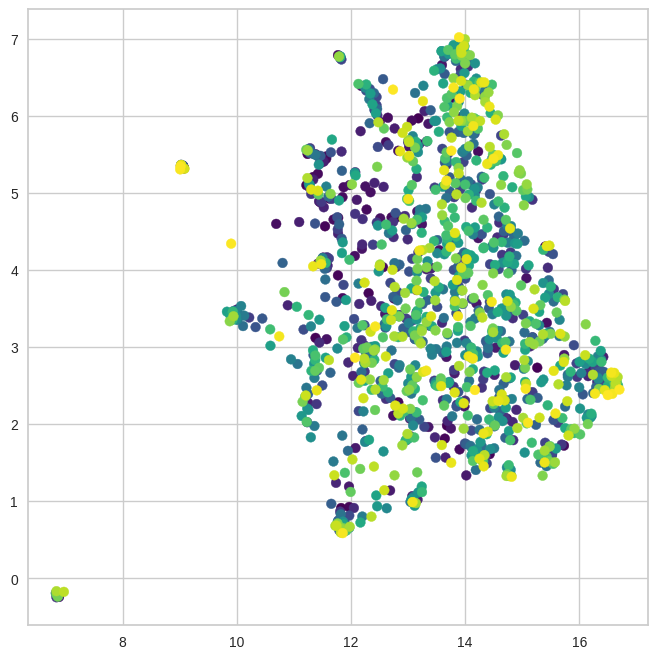

In [ ]:
draw_umap(tfidf_matrix.toarray(),n_neighbors=100, n_components=2, metric='cosine', title='')

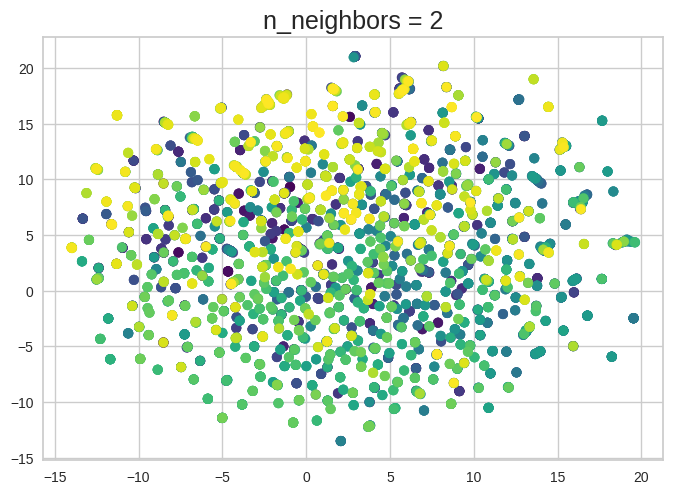

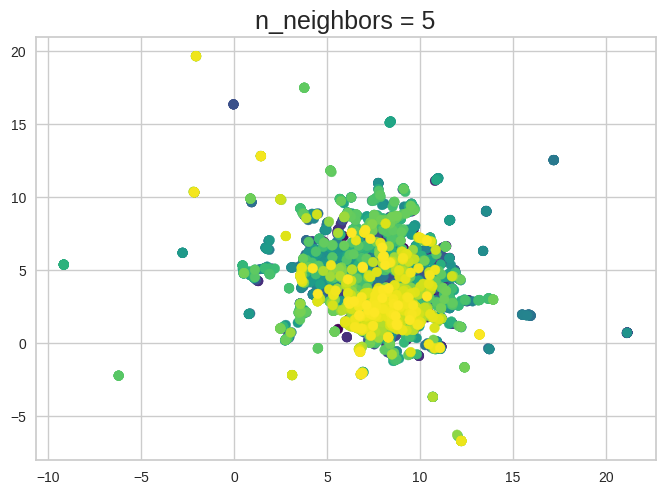

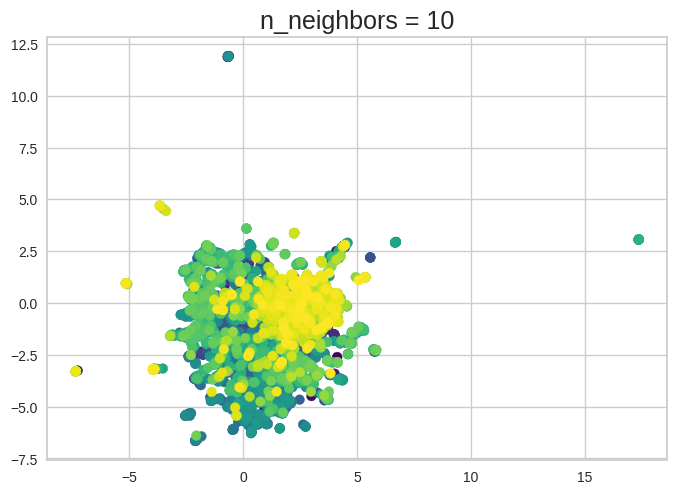

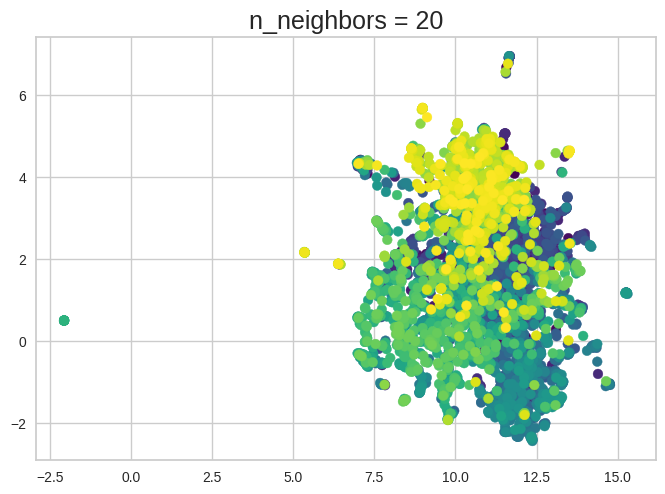

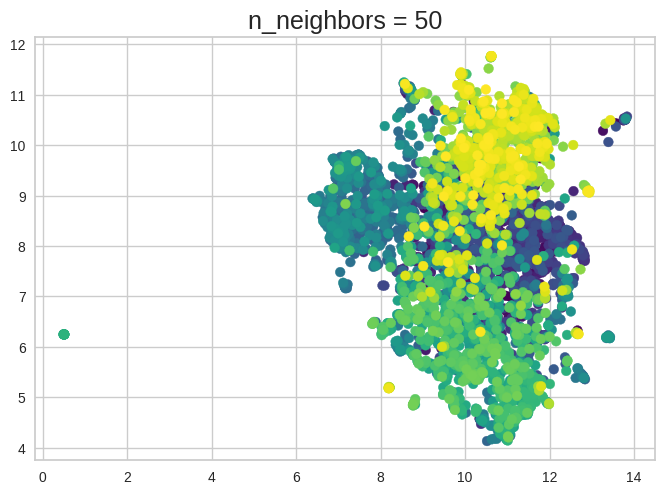

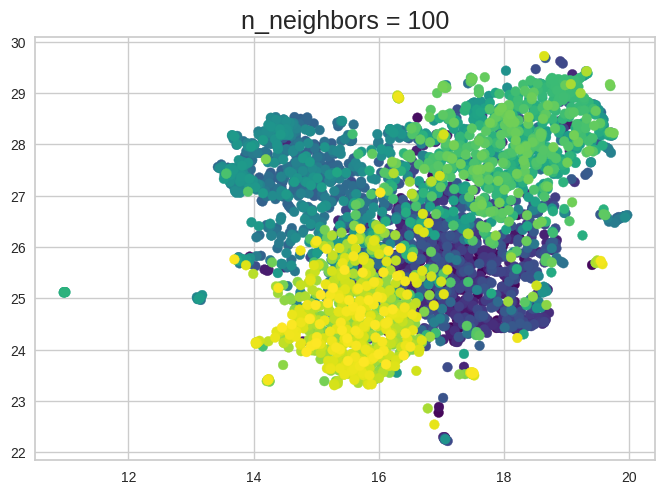

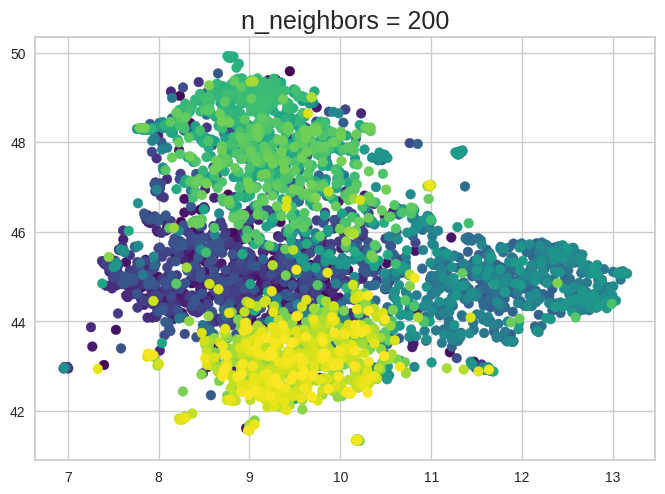

In [ ]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(tfidf_matrix.toarray(),n_neighbors=n, title='n_neighbors = {}'.format(n))

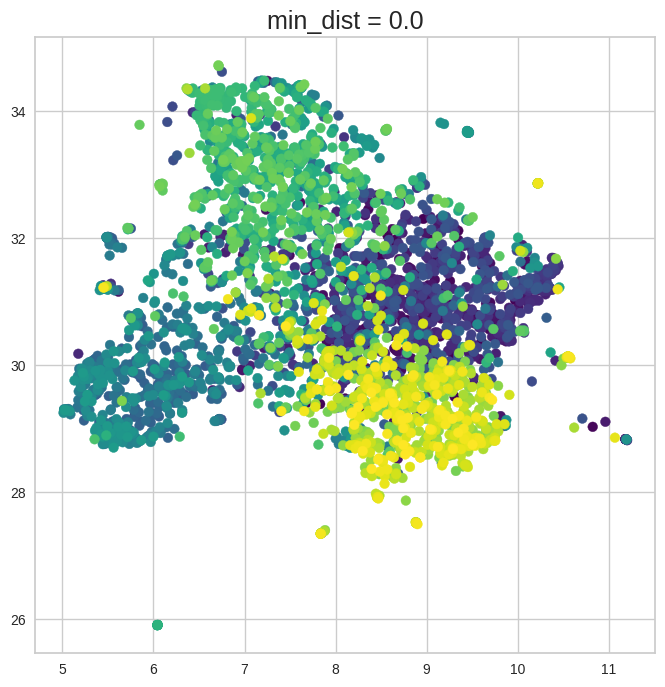

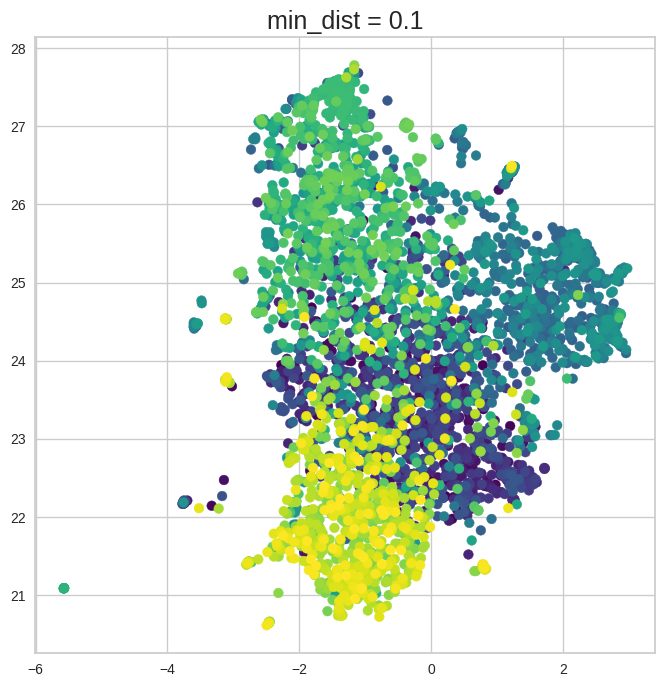

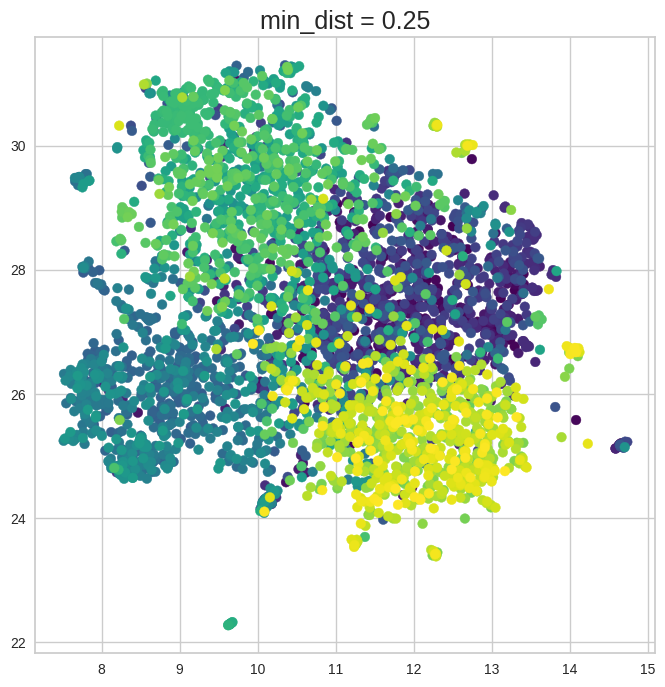

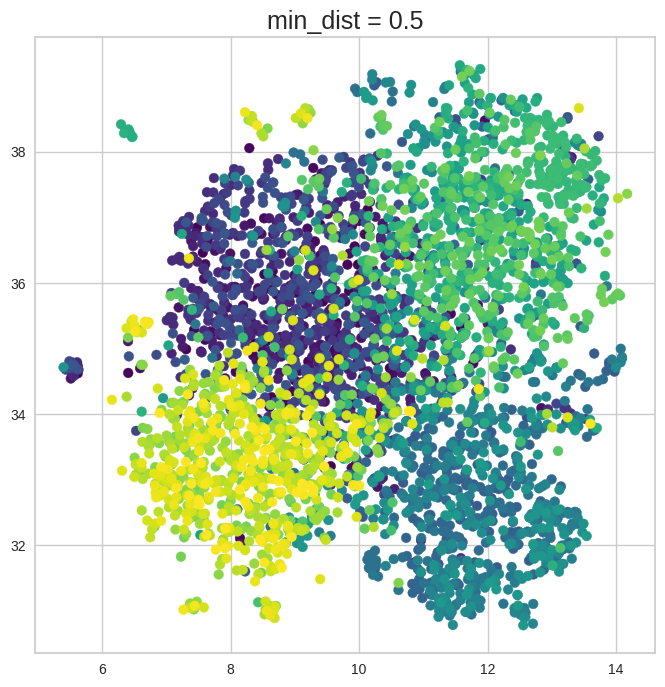

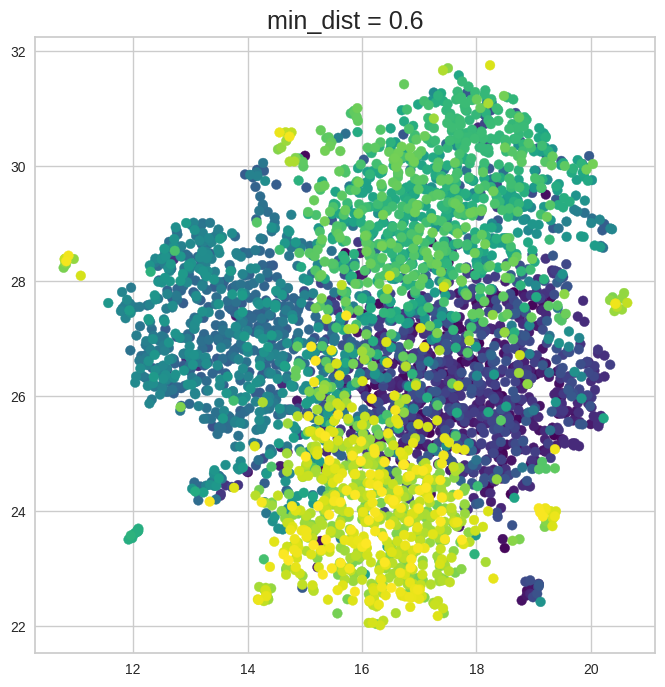

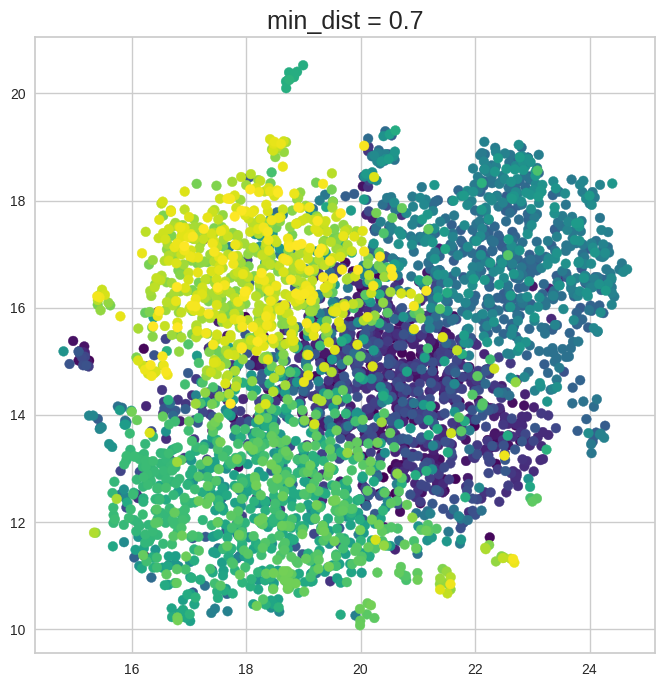

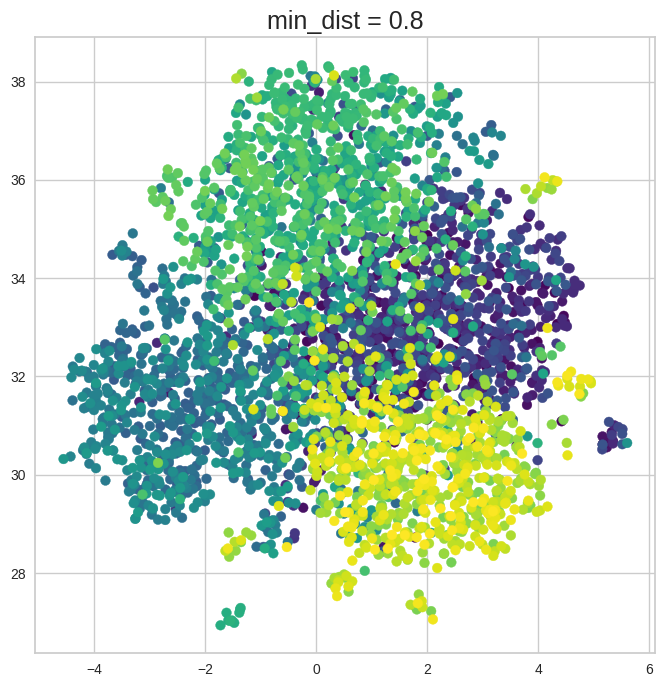

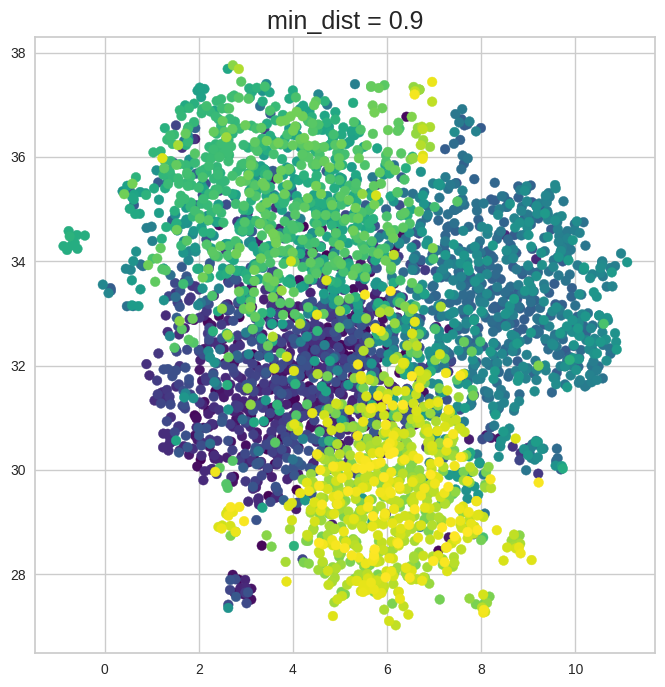

In [ ]:
for d in (0.0, 0.1, 0.25, 0.5, 0.6, 0.7 ,0.8 ,0.9):
    draw_umap(tfidf_matrix.toarray(),min_dist=d, title='min_dist = {}'.format(d))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


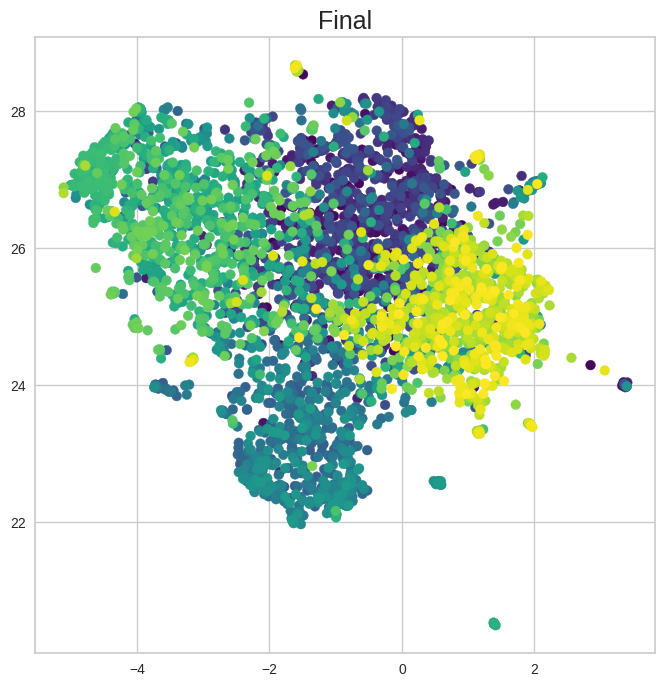

In [ ]:
draw_umap(tfidf_matrix.toarray(), n_neighbors=100, min_dist=0.15, n_components=2, metric='cosine', title='Final')

In [ ]:
# matrix = reduced_matrix

## **Clustering:**

### **Specify Number of Evens Needed:**

In [ ]:
Number_Events = 2
Top_keywords = 2

if 'H' in window_size:
    window = int(window_size.replace('H', ''))
    time_unit = 'Hours'
elif 'M' in window_size:
    window = int(window_size.replace('M', ''))
    time_unit = 'Minutes'
else:
    window = int(window_size.replace('S', ''))
    time_unit = 'Seconds'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **DBSCAN Clustering**

In [ ]:
# DBSCAN Clustering
# epsilons = np.linspace(0.1 , 0.9, num = 15)
# min_samples = np.arange(2,20 ,step = 3)
epsilons = [0.5]
min_samples = [5]
combinations = list(itertools.product(epsilons,min_samples))
result = DBSCAN_clustering(combinations , matrix)
labels = result['best_labels']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1, Silhouette Score: 0.08827905012107472, Number of Clusters: 20


In [ ]:
best_labels = labels
# best_labels = result['best_labels']
labels_set = set(best_labels)
num_clusters = np.amax(list((labels_set)))+1
print('Number of clusters:', num_clusters)
df['dbscan'] = best_labels

Number of clusters: 20


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("dbscan",df , categorized_tweets_indexes,num_clusters ,window_size)
df['dbscan'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dbscan
-1     1658
 0      201
 6       22
 8       22
 1       16
 3       16
 5       11
 7       10
 15       9
 4        9
 14       7
 9        7
 2        7
 10       6
 18       6
 11       5
 12       5
 13       5
 16       5
 17       5
 19       5
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


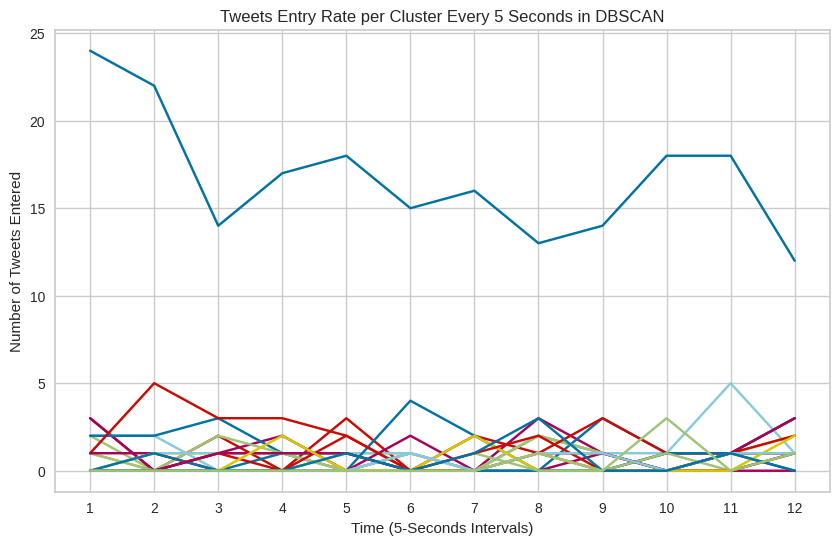

In [ ]:
# Plotting Tweets Entry rate for the DBSCAN clusters
plt.figure(figsize=(10, 6))
for cluster, entry_rates in tweets_entry_rate.items():
    plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')

plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in DBSCAN')
plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
plt.ylabel('Number of Tweets Entered')
plt.xticks(range(1, len(entry_rates) + 1))
# plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Ranking the Clusters
sorted_clusters = get_clusters_sorted(tweets_entry_rate,Number_Events)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(sorted_clusters)

[(1, 13.0), (5, 12.0), (7, 12.0), (10, 12.0), (3, 10.0), (8, 8.0), (9, 8.0), (2, 7.0), (4, 6.0), (15, 6.0), (11, 5.0), (12, 5.0), (13, 5.0), (14, 5.0), (16, 5.0), (18, 5.0), (6, 4.0), (19, 4.0), (20, 4.0), (17, 3.0), (0, 2.0)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Top Events
get_events(sorted_clusters ,clusters_tweets ,clusters_tweets_original ,Top_keywords,Number_Events)

In [ ]:
keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, [100,100,100,100,100,100,100,100,100,100])

['chelsea', 'goal', '#cfcwembley', '#facupfinal']
Event 1 Top 100 Keywords : ['chelsea', 'goal', 'drogba']
Tweet : ['chelsea', 'goal']

['goaaaaal', 'dider', 'drogba', 'wembley', 'king', '#cfc']
Event 2 Top 100 Keywords : ['dider', 'drogba', 'goaaaaal', 'king', 'wembley', 'drog']
Tweet : ['goaaaaal', 'dider', 'drogba', 'wembley', 'king']

['goal', 'didier', 'drogba', 'put', 'chelsea', '2-0', '52nd', 'minute', '#facupfinal']
Event 3 Top 100 Keywords : ['2-0', '52nd', 'chelsea', 'didier', 'drogba', 'goal', 'minute', 'put']
Tweet : ['goal', 'didier', 'drogba', 'put', 'chelsea', '2-0', '52nd', 'minute']

['drogba', '2-0', '#facupfinal', 'game']
Event 4 Top 100 Keywords : ['2-0', 'drogba', 'game']
Tweet : ['drogba', '2-0', 'game']

['retweet', 'think', 'chelsea', 'see', 'win', '#facupfinal']
Event 5 Top 100 Keywords : ['chelsea', 'retweet', 'see', 'think', 'win']
Tweet : ['retweet', 'think', 'chelsea', 'see', 'win']

['swimming', 'pool', 'titanic', 'useful', 'jordan', 'henderson', '#facupfi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **HDBSCAN Clustering**

In [ ]:
# HDBSCAN Clustering
# min_cluster_size_array = np.arange(5,30 ,step = 3)
min_cluster_size_array = [5]
result = HDBSCAN_clustering(min_cluster_size_array , matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


In [ ]:
best_labels =result['best_labels']
labels_set = set(best_labels)
num_clusters = np.amax(list((labels_set)))+1
print('Number of clusters:', num_clusters)
df['hdbscan'] = result['best_labels']

Number of clusters: 20


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("hdbscan",df , categorized_tweets_indexes,num_clusters ,window_size)
df['hdbscan'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


hdbscan
-1     1605
 16     204
 13      29
 12      22
 8       21
 5       17
 18      17
 4       14
 6       13
 7       11
 17      10
 0        9
 15       9
 2        9
 11       8
 10       8
 9        7
 19       7
 3        7
 14       5
 1        5
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


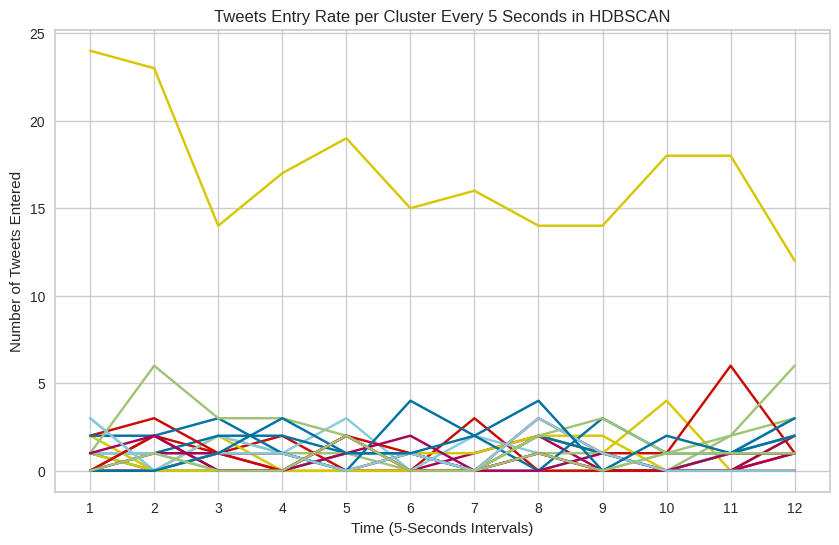

In [ ]:
# Plotting Tweets Entry rate for the DBSCAN clusters
plt.figure(figsize=(10, 6))
for cluster, entry_rates in tweets_entry_rate.items():
    plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')

plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in HDBSCAN')
plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
plt.ylabel('Number of Tweets Entered')
plt.xticks(range(1, len(entry_rates) + 1))
# plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Ranking the Clusters
sorted_clusters = get_clusters_sorted(tweets_entry_rate,Number_Events)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Top Events
get_events(sorted_clusters ,clusters_tweets ,clusters_tweets_original ,Top_keywords,Number_Events)

Event 1: 
  Top 8 Keywords : ['yellow' 'card' 'agger' '#facupfinal' '#facup' '#lfc' '#cfc' 'gets']
  Representative Tweet : Agger gets a yellow. #LFC #CFC #FACupFinal
  Sentiment : Neutral
  Related Topics : ['sports']

Event 2: 
  Top 8 Keywords : ['#facupfinal' '2' 'biggest' 'gathering' 'historic' 'officially' 'one'
 'racists']
  Representative Tweet : RT @Arsenes_Eyes: A historic #FACupFinal today. This is officially the biggest gathering of racists in one stadium since World War 2.
  Sentiment : Positive
  Related Topics : ['sports']

Event 3: 
  Top 8 Keywords : ['anthem' 'national' 'fans' '#cfc' '#lfc' 'even' 'sad' 'sang']
  Representative Tweet : RT @henrywinter: #cfc fans sang the National Anthem. Many #lfc fans didn't, even jeering it. They jeered the National Anthem. Sad.
  Sentiment : Negative
  Related Topics : ['sports']

Event 4: 
  Top 8 Keywords : ['#facupfinal' 'luis' 'suarez' 'banter' 'john' 'kick' 'off' 'sharing']
  Representative Tweet : RT @Will_Hoe: John Terry and

In [ ]:
keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, [100,100,100,100,100,100,100,100,100,100])

['swimming', 'pool', 'titanic', 'useful', 'jordan', 'henderson', '#facupfinal']
Event 1 Top 100 Keywords : ['henderson', 'jordan', 'pool', 'swimming', 'titanic', 'useful']
Tweet : ['swimming', 'pool', 'titanic', 'useful', 'jordan', 'henderson']

['pass', 'lampard', '#cfc']
Event 2 Top 100 Keywords : ['lampard', 'pass', 'lovely', 'score', 'superb', '2-0', 'drogba', 'goal', 'great', 'off', 'wembley']
Tweet : ['pass', 'lampard']

['absolute', 'legend', '#drogba', 'love', 'much', '#cfcwembley']
Event 3 Top 100 Keywords : ['absolute', 'legend', 'love', 'much']
Tweet : ['absolute', 'legend', 'love', 'much']

['goal', 'didier', 'drogba', 'put', 'chelsea', '2-0', '52nd', 'minute', '#facupfinal']
Event 4 Top 100 Keywords : ['2-0', 'drogba', 'didier', 'goal', 'put', '52nd', 'chelsea', 'minute', 'leads', 'liverpool']
Tweet : ['goal', 'didier', 'drogba', 'put', 'chelsea', '2-0', '52nd', 'minute']

['looks', 'like', 'chelsea', 'win', '#facupfinal']
Event 5 Top 100 Keywords : ['looks', 'like', 'chel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Evaluation Module:**

## **Folders Locations:**

In [ ]:
# FA Cup Dataset
FACup_tweets_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_tweets_english'
FACup_groundTruth_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_ground_truth_topics'
FACup_results_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_result_topics'
FACup_graphs_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_clusters_graphs'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Super Tuesday Dataset
SuperTuesday_tweets_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/super_tuesday/SuperTuesday_tweets_english'
SuperTuesday_groundTruth_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/super_tuesday/SuperTuesday_ground_truth_topics'
SuperTuesday_results_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/super_tuesday/SuperTuesday_result_topics'
SuperTuesday_graphs_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/super_tuesday/SuperTuesday_clusters_graphs'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# US Elections Dataset
USElections_tweets_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/us_elections/USElections_tweets_english'
USElections_groundTruth_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/us_elections/USElections_ground_truth_topics'
USElections_results_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/us_elections/USElections_result_topics'
USElections_graphs_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/us_elections/USElections_clusters_graphs'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def count_words_in_line(line):
    line = re.sub(r'\[[^\]]+\]', '<>', line)
    line = line.replace(';', ' ')
    words = line.split()
    words = [word.replace('<>', '[') for word in words]
    word_count = len(words)
    return word_count
# def read_text_file_and_count_words(filename):
#     word_counts = []
#     with open(filename, 'r',encoding='latin-1') as file:
#         for line in file:
#             line_words = count_words_in_line(line)
#             if line_words > 0:
#                 word_counts.append(line_words)
#     return word_counts

def read_text_file_and_count_words(filename, max_lines=None):
    word_counts = []
    lines_to_keep = []
    with open(filename, 'r', encoding='latin-1') as file:
        for i, line in enumerate(file):
            if max_lines is not None and i >= max_lines:
                break  # Stop reading lines if maximum number of lines reached
            line_words = count_words_in_line(line)
            if line_words > 0:
                word_counts.append(line_words)
            lines_to_keep.append(line)
    # Write back only the first `max_lines` to the file
    with open(filename, 'w', encoding='latin-1') as file:
        file.writelines(lines_to_keep)
    return word_counts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Early phase of Evaluation:**

In [ ]:
# Detect Events for the Dataset
def Detect_Event_In_Dataset(tweets_path,groundTruth_path,results_path,graphs_path ,window_size='5S' ,num_groups = 6 ,Number_keywords = 2 ,useFiltering = True , useUMAP = False):
    if 'H' in window_size:
        window = int(window_size.replace('H', ''))
        time_unit = 'Hours'
    elif 'M' in window_size:
        window = int(window_size.replace('M', ''))
        time_unit = 'Minutes'
    else:
        window = int(window_size.replace('S', ''))
        time_unit = 'Seconds'

    results_DBSCAN_path = results_path + '/DBSCAN'
    results_HDBSCAN_path = results_path + '/HDBSCAN'
    graphs_DBSCAN_path = graphs_path + '/DBSCAN'
    graphs_HDBSCAN_path = graphs_path + '/HDBSCAN'

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    if not os.path.exists(results_DBSCAN_path):
        os.makedirs(results_DBSCAN_path)
    if not os.path.exists(results_HDBSCAN_path):
        os.makedirs(results_HDBSCAN_path)

    if not os.path.exists(graphs_path):
        os.makedirs(graphs_path)
    if not os.path.exists(graphs_DBSCAN_path):
        os.makedirs(graphs_DBSCAN_path)
    if not os.path.exists(graphs_HDBSCAN_path):
        os.makedirs(graphs_HDBSCAN_path)

    groundTruth_files = os.listdir(groundTruth_path)
    groundTruth_files = sorted(groundTruth_files)
    Count=1
    for filename in groundTruth_files:
        events_to_detect = read_text_file_and_count_words(os.path.join(groundTruth_path, filename))
        events_to_detect = [Number_keywords for x in events_to_detect]
        input_filename = os.path.splitext(filename)[0] + '.json'
        input_file_path = os.path.join(tweets_path, input_filename)
        with open(input_file_path, 'r',encoding='latin-1') as f:
            json_data = f.readlines()
        json_objects = [json.loads(obj.strip()) for obj in json_data]
        for obj in json_objects:
            obj['user'] = obj['user']['screen_name']
        df = pd.DataFrame(json_objects)
        df.drop(columns=['id_str'], inplace=True)
        df = df.rename(columns={'created_at': 'TweetDate', 'text': 'TweetText'})

#         df['is_english'] = df['TweetText'].apply(detect_english)
#         filtered_non_english = df[~df['is_english']]
#         df = df[df['is_english']]
        print()
        print(f"({Count}) {filename}: {df.shape[0]} Rows")
        Count = Count+1
        print()

        preprocess_dataframe(df)
        categorized_tweets , categorized_tweets_indexes  = categorize_tweets(df,window_size)
        tfidf_matrix , features = compute_tfidf_matrix(df['Text'])

        if useFiltering :
            if useUMAP :
                reduced_matrix = UMAP(n_neighbors=100, n_components=5, min_dist=0.15, metric='cosine' ).fit_transform(tfidf_matrix)
                collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,reduced_matrix ,num_groups)
            else:
                collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,tfidf_matrix ,num_groups)
            categorized_tweets , categorized_tweets_indexes = remove_unique_tweets(df ,window_size)
            tfidf_matrix , features = compute_tfidf_matrix(df['Text'])
        if useUMAP :
            reduced_matrix = UMAP(n_neighbors=100, n_components=5, min_dist=0.15, metric='cosine' ).fit_transform(tfidf_matrix)
        else:
            reduced_matrix = tfidf_matrix

        matrix = tfidf_matrix

        if df.shape[0] < 1000 :
            min = 5
            epsilons = [0.9]
            min_samples = [5]
        else:
            min = 10
            epsilons = [0.65]
            min_samples = [15]
        # DBSCAN Results
        # epsilons = np.linspace(0.1 , 0.9, num = 10)
        # min_samples = np.arange(min,20 ,step = 3)

        combinations = list(itertools.product(epsilons,min_samples))

        result = DBSCAN_clustering(combinations , matrix)
        best_labels = result['best_labels']
        num_clusters = np.amax(list(set(best_labels)))+1
        df['dbscan'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("dbscan",df , categorized_tweets_indexes,num_clusters ,window_size)

#         plt.figure(figsize=(10, 6))
#         for cluster, entry_rates in tweets_entry_rate.items():
#             plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')
#         plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in DBSCAN')
#         plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
#         plt.ylabel('Number of Tweets Entered')
#         plt.xticks(range(1, len(entry_rates) + 1))
#         plt.grid(True)
#         plt.savefig(os.path.join(graphs_DBSCAN_path, f"{os.path.splitext(filename)[0]}.png"))
#         plt.close()

        sorted_clusters = get_clusters_sorted(tweets_entry_rate,len(events_to_detect))

        print(f"DBSCAN Score: {result['best_score']} , Epsilon: {result['best_epsilon']} , Min_samples: {result['best_min_samples']}")
        keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, events_to_detect)

        output_file_path = os.path.join(results_DBSCAN_path, filename)

        with open(output_file_path, 'w') as f:
            for inner_array in keywords:
                line = ' '.join(inner_array)
                f.write(line + '\n')

        # HDBSCAN Results
        # min_cluster_size_array = np.arange(min,20 ,step = 3)
        result = HDBSCAN_clustering(min_samples , matrix)
        best_labels =result['best_labels']
        labels_set = set(best_labels)
        num_clusters = np.amax(list((labels_set)))+1
        df['hdbscan'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("hdbscan",df , categorized_tweets_indexes,num_clusters ,window_size)

#         plt.figure(figsize=(10, 6))
#         for cluster, entry_rates in tweets_entry_rate.items():
#             plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')
#         plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in HDBSCAN')
#         plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
#         plt.ylabel('Number of Tweets Entered')
#         plt.xticks(range(1, len(entry_rates) + 1))
#         plt.grid(True)
#         plt.savefig(os.path.join(graphs_HDBSCAN_path, f"{os.path.splitext(filename)[0]}.png"))
#         plt.close()

        sorted_clusters = get_clusters_sorted(tweets_entry_rate,len(events_to_detect))
        print(f"HDBSCAN Score: {result['best_score']} , Min cluster size: {result['best_min_cluster_size']}")
        keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, events_to_detect)

        output_file_path = os.path.join(results_HDBSCAN_path, filename)

        with open(output_file_path, 'w') as f:
            for inner_array in keywords:
                line = ' '.join(inner_array)
                f.write(line + '\n')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def Evaluate_Results(groundTruth_path,results_path):
    results_DBSCAN_path = results_path + '/DBSCAN'
    results_HDBSCAN_path = results_path + '/HDBSCAN'
    java_script_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/TopicEvaluator/TopicEvaluator.jar'

    java_command_DBSCAN = ['java', '-jar', java_script_path, groundTruth_path, results_DBSCAN_path, '10', '10', '10']
    output_DBSCAN = subprocess.run(java_command_DBSCAN, capture_output=True, text=True).stdout

    java_command_HDBSCAN = ['java', '-jar', java_script_path, groundTruth_path, results_HDBSCAN_path, '10', '10', '10']
    output_HDBSCAN = subprocess.run(java_command_HDBSCAN, capture_output=True, text=True).stdout

    print(output_DBSCAN)
    print(output_HDBSCAN)
    recall_regex = r"Results @\d+: \(topic recall \/ term precision \/ term recall\)\n([\d.]+) \(\d+\/\d+\)"
    allvalues = r"\d+\.\d+"

    topic_recall_DBSCAN = re.findall(recall_regex, output_DBSCAN)
    AllValues_DBSCAN = re.findall(allvalues, output_DBSCAN)
    term_precision_DBSCAN = [AllValues_DBSCAN[i] for i in range(1 , len(AllValues_DBSCAN), 3)]
    term_recall_DBSCAN =[AllValues_DBSCAN[i] for i in range(2, len(AllValues_DBSCAN), 3)]

    topic_recall_HDBSCAN = re.findall(recall_regex, output_HDBSCAN)
    AllValues_HDBSCAN = re.findall(allvalues, output_HDBSCAN)
    term_precision_HDBSCAN = [AllValues_HDBSCAN[i] for i in range(1, len(AllValues_HDBSCAN), 3)]
    term_recall_HDBSCAN = [AllValues_HDBSCAN[i] for i in range(2 , len(AllValues_HDBSCAN), 3)]

    print("DBSCAN Results:")
    # print(output_DBSCAN)
    print("Topic Recall:", topic_recall_DBSCAN[0])
    print("Term Precision:", term_precision_DBSCAN[0])
    # print("Term Recall:", term_recall_DBSCAN[0])
    print()

    print("HDBSCAN Results:")
    # print(output_HDBSCAN)
    print("Topic Recall:", topic_recall_HDBSCAN[0])
    print("Term Precision:", term_precision_HDBSCAN[0])
    # print("Term Recall:", term_recall_HDBSCAN[0])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# %%capture
Detect_Event_In_Dataset(FACup_tweets_path,FACup_groundTruth_path,FACup_results_path,FACup_graphs_path ,window_size='5S' ,num_groups = 6 ,Number_keywords =2 ,useFiltering = False , useUMAP = False )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



(1) 5_5_2012_16_16.txt: 2233 Rows

Number of Rows After Preprocessing: 1965


KeyboardInterrupt: 

In [ ]:
print("Without Filtering")
Evaluate_Results(FACup_groundTruth_path,FACup_results_path)


In [ ]:
print("With Filtering")
Evaluate_Results(FACup_groundTruth_path,FACup_results_path)

In [ ]:
print("With Filtering using UMAP")
Evaluate_Results(FACup_groundTruth_path,FACup_results_path)

In [ ]:
# %%capture
Detect_Event_In_Dataset(SuperTuesday_tweets_path,SuperTuesday_groundTruth_path,SuperTuesday_results_path,SuperTuesday_graphs_path ,window_size='5M' ,num_groups = 4,useFiltering = False , useUMAP = True  )

In [ ]:
Evaluate_Results(SuperTuesday_groundTruth_path,SuperTuesday_results_path)

In [ ]:
%%capture
Detect_Event_In_Dataset(USElections_tweets_path,USElections_groundTruth_path,USElections_results_path,USElections_graphs_path ,window_size='1M' ,num_groups = 4 )

In [ ]:
Evaluate_Results(USElections_groundTruth_path,USElections_results_path)

## **Evaluation Using Keywords:**

In [ ]:
from sklearn.decomposition import PCA
def Evaluate_number_of_keywords(tests,tweets_path ,groundTruth_path,results_path , graphs_path ,window_size='5S' ,num_groups = 6  ,useFiltering = False , useUMAP = False):
    DBSCAN_recall = []
    DBSCAN_precision = []
    DBSCAN_term_recall = []

    HDBSCAN_recall = []
    HDBSCAN_precision = []
    HDBSCAN_term_recall = []

    kmeans_recall = []
    kmeans_precision = []
    kmeans_term_recall = []

    # Detect_Event_In_Dataset(tweets_path,groundTruth_path,results_path,graphs_path ,window_size ,num_groups ,num ,useFiltering , useUMAP )
    if 'H' in window_size:
        window = int(window_size.replace('H', ''))
        time_unit = 'Hours'
    elif 'M' in window_size:
        window = int(window_size.replace('M', ''))
        time_unit = 'Minutes'
    else:
        window = int(window_size.replace('S', ''))
        time_unit = 'Seconds'

    results_DBSCAN_path = results_path + '/DBSCAN'
    results_HDBSCAN_path = results_path + '/HDBSCAN'
    results_kmeans_path = results_path + '/kmeans'

    graphs_DBSCAN_path = graphs_path + '/DBSCAN'
    graphs_HDBSCAN_path = graphs_path + '/HDBSCAN'
    graphs_kmeans_path = graphs_path + '/kmeans'

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    if not os.path.exists(results_DBSCAN_path):
        os.makedirs(results_DBSCAN_path)
    if not os.path.exists(results_HDBSCAN_path):
        os.makedirs(results_HDBSCAN_path)
    if not os.path.exists(results_kmeans_path):
        os.makedirs(results_kmeans_path)

    if not os.path.exists(graphs_path):
        os.makedirs(graphs_path)
    if not os.path.exists(graphs_DBSCAN_path):
        os.makedirs(graphs_DBSCAN_path)
    if not os.path.exists(graphs_HDBSCAN_path):
        os.makedirs(graphs_HDBSCAN_path)
    if not os.path.exists(graphs_kmeans_path):
        os.makedirs(graphs_kmeans_path)

    groundTruth_files = os.listdir(groundTruth_path)
    groundTruth_files = sorted(groundTruth_files)
    Count=1
    keywords_DBSCAN_results = OrderedDict()
    keywords_HDBSCAN_results = OrderedDict()
    keywords_kmeans_results = OrderedDict()

    for filename in groundTruth_files:
        keywords_DBSCAN_results[filename] = []
        keywords_HDBSCAN_results[filename] = []
        keywords_kmeans_results[filename] = []

    for filename in groundTruth_files:
        events_to_detect = read_text_file_and_count_words(os.path.join(groundTruth_path, filename))
        input_filename = os.path.splitext(filename)[0] + '.json'
        input_file_path = os.path.join(tweets_path, input_filename)
        with open(input_file_path, 'r',encoding='latin-1') as f:
            json_data = f.readlines()
        json_objects = [json.loads(obj.strip()) for obj in json_data]
        for obj in json_objects:
            obj['user'] = obj['user']['screen_name']
        df = pd.DataFrame(json_objects)
        df.drop(columns=['id_str'], inplace=True)
        df = df.rename(columns={'created_at': 'TweetDate', 'text': 'TweetText'})

        print()
        print(f"({Count}) {filename}: {df.shape[0]} Rows")
        Count = Count+1
        print()

        preprocess_dataframe(df)
        categorized_tweets , categorized_tweets_indexes  = categorize_tweets(df,window_size)
        tfidf_matrix , features = compute_tfidf_matrix(df['Text'])

        if useFiltering :
            if useUMAP :
                reduced_matrix = UMAP(n_neighbors=100, n_components=5, min_dist=0.15, metric='cosine' ).fit_transform(tfidf_matrix)
                collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,reduced_matrix ,num_groups = num_groups)
            else:
                collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,tfidf_matrix ,num_groups = num_groups)
            num_unique_rows = df[df['Type'] == 'Not Unique'].shape[0]
            num_not_unique_rows = df[df['Type'] == 'Unique'].shape[0]
            print('Not Unique',num_unique_rows)
            print('Unique',num_not_unique_rows)
            categorized_tweets , categorized_tweets_indexes = remove_unique_tweets(df ,window_size)
            tfidf_matrix , features = compute_tfidf_matrix(df['Text'])
            print(f"Number of Rows After Filtering: {len(df)}")
        if useUMAP :
            reduced_matrix = UMAP(n_neighbors=10, n_components=100, min_dist=0.2, metric='cosine' ).fit_transform(tfidf_matrix)
        else:
            reduced_matrix = tfidf_matrix

        matrix = tfidf_matrix
        epsilons = [0.5 ,0.65 ,0.8,0.9]
        min_samples = [2 ,5 , 7]

        # DBSCAN Results
        combinations = list(itertools.product(epsilons,min_samples))
        # cosine_sim_matrix = cosine_similarity(tfidf_matrix)
        result = DBSCAN_clustering(combinations , matrix)
        best_labels = result['best_labels']
        num_clusters = np.amax(list(set(best_labels)))+1
        kmeans_clusters =num_clusters
        df['dbscan'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("dbscan",df , categorized_tweets_indexes,num_clusters ,window_size)

        sorted_clusters = get_clusters_sorted(tweets_entry_rate)

        print(f"DBSCAN Score: {result['best_score']} , Epsilon: {result['best_epsilon']} , Min_samples: {result['best_min_samples']}")
        topics_num = 4
        for num in tests:
#             DBSCAN_events_to_detect = [num for x in events_to_detect]
            DBSCAN_events_to_detect = [num] * topics_num
            keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, DBSCAN_events_to_detect)
            keywords_DBSCAN_results[filename].append(keywords)

        plt.figure(figsize=(10, 6))
        for cluster, entry_rates in tweets_entry_rate.items():
            plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')
        plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in DBSCAN')
        plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
        plt.ylabel('Number of Tweets Entered')
        plt.xticks(range(1, len(entry_rates) + 1))
        plt.grid(True)
        plt.savefig(os.path.join(graphs_DBSCAN_path, f"{os.path.splitext(filename)[0]}.png"))
        plt.close()
        # HDBSCAN Results

        result = HDBSCAN_clustering(min_samples , matrix)

        best_labels =result['best_labels']
        labels_set = set(best_labels)
        print(labels_set)
        num_clusters = np.amax(list((labels_set)))+1
        df['hdbscan'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("hdbscan",df , categorized_tweets_indexes,num_clusters ,window_size)

        sorted_clusters = get_clusters_sorted(tweets_entry_rate)
        print(f"HDBSCAN Score: {result['best_score']} , Min cluster size: {result['best_min_cluster_size']}")

        for num in tests:
#             HDBSCAN_events_to_detect = [num for x in events_to_detect]
            HDBSCAN_events_to_detect = [num] * topics_num
            keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, HDBSCAN_events_to_detect)
            keywords_HDBSCAN_results[filename].append(keywords)

        plt.figure(figsize=(10, 6))
        for cluster, entry_rates in tweets_entry_rate.items():
            plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')
        # plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in DBSCAN')
        plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
        plt.ylabel('Number of Tweets Entered')
        plt.xticks(range(1, len(entry_rates) + 1))
        plt.grid(True)
        plt.savefig(os.path.join(graphs_HDBSCAN_path, f"{os.path.splitext(filename)[0]}.png"))
        plt.close()

        # Kmeans Results
        result = kmeans_clustering(matrix,minRange = kmeans_clusters ,maxRange = kmeans_clusters+1 ,step=2)
        best_labels =result['best_labels']
        labels_set = set(best_labels)
        num_clusters = np.amax(list((labels_set)))+1
        df['kmeans'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("kmeans",df , categorized_tweets_indexes,num_clusters ,window_size)

        sorted_clusters = get_clusters_sorted(tweets_entry_rate)
        print(f"kmeans Score: {result['best_score']} , Number of Cluster: {result['best_numClusters']}")

        for num in tests:
#             kmeans_events_to_detect = [num for x in events_to_detect]
            kmeans_events_to_detect= [num] * topics_num
            keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, kmeans_events_to_detect)
            keywords_kmeans_results[filename].append(keywords)

    for i , num in enumerate(tests):
        for filename in groundTruth_files:
            output_file_path = os.path.join(results_DBSCAN_path, filename)
            with open(output_file_path, 'w') as f:
                for inner_array in keywords_DBSCAN_results[filename][i]:
                    line = ' '.join(inner_array)
                    f.write(line + '\n')

            output_file_path = os.path.join(results_HDBSCAN_path, filename)

            with open(output_file_path, 'w') as f:
                for inner_array in keywords_HDBSCAN_results[filename][i]:
                    line = ' '.join(inner_array)
                    f.write(line + '\n')

            output_file_path = os.path.join(results_kmeans_path, filename)

            with open(output_file_path, 'w') as f:
                for inner_array in keywords_kmeans_results[filename][i]:
                    line = ' '.join(inner_array)
                    f.write(line + '\n')
        # #####

        java_script_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/TopicEvaluator/TopicEvaluator.jar'

        java_command_DBSCAN = ['java', '-jar', java_script_path, groundTruth_path, results_DBSCAN_path, '100', '100', '10']
        output_DBSCAN = subprocess.run(java_command_DBSCAN, capture_output=True, text=True).stdout

        java_command_HDBSCAN = ['java', '-jar', java_script_path, groundTruth_path, results_HDBSCAN_path, '100', '100', '10']
        output_HDBSCAN = subprocess.run(java_command_HDBSCAN, capture_output=True, text=True).stdout

        java_command_kmeans = ['java', '-jar', java_script_path, groundTruth_path, results_kmeans_path, '100', '100', '10']
        output_kmeans = subprocess.run(java_command_kmeans, capture_output=True, text=True).stdout

        print(f"DBSCAN: {output_DBSCAN}")
        print(f"HDBSCAN: {output_HDBSCAN}")
        print(f"Kmeans: {output_kmeans}")

        pattern = r'Results @100: \(topic recall \/ term precision \/ term recall\)\s*([\d\.]+) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)'
        AllValues_DBSCAN = re.search(pattern, output_DBSCAN)
        AllValues_HDBSCAN = re.search(pattern, output_HDBSCAN)
        AllValues_kmeans = re.search(pattern, output_kmeans)

        DBSCAN_recall.append(float(AllValues_DBSCAN.group(1)) if AllValues_DBSCAN.group(1) != 'NaN' else 0)
        DBSCAN_precision.append(float(AllValues_DBSCAN.group(4)) if AllValues_DBSCAN.group(4) != 'NaN' else 0)
        DBSCAN_term_recall.append(float(AllValues_DBSCAN.group(7)) if AllValues_DBSCAN.group(7) != 'NaN' else 0)

        HDBSCAN_recall.append(float(AllValues_HDBSCAN.group(1)) if AllValues_HDBSCAN.group(1) != 'NaN' else 0)
        HDBSCAN_precision.append(float(AllValues_HDBSCAN.group(4)) if AllValues_HDBSCAN.group(4) != 'NaN' else 0)
        HDBSCAN_term_recall.append(float(AllValues_HDBSCAN.group(7)) if AllValues_HDBSCAN.group(7) != 'NaN' else 0)

        kmeans_recall.append(float(AllValues_kmeans.group(1)) if AllValues_kmeans.group(1) != 'NaN' else 0)
        kmeans_precision.append(float(AllValues_kmeans.group(4)) if AllValues_kmeans.group(4) != 'NaN' else 0)
        kmeans_term_recall.append(float(AllValues_kmeans.group(7)) if AllValues_kmeans.group(7) != 'NaN' else 0)

    return DBSCAN_recall , DBSCAN_precision ,DBSCAN_term_recall, HDBSCAN_recall , HDBSCAN_precision ,HDBSCAN_term_recall, kmeans_recall ,kmeans_precision,kmeans_term_recall

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.decomposition import PCA
def Evaluate_number_of_Topics(tests,tweets_path ,groundTruth_path,results_path , graphs_path ,window_size='5S' ,num_groups = 6  ,useFiltering = False , useUMAP = False):
    DBSCAN_recall = []
    DBSCAN_precision = []
    DBSCAN_term_recall = []

    HDBSCAN_recall = []
    HDBSCAN_precision = []
    HDBSCAN_term_recall = []

    kmeans_recall = []
    kmeans_precision = []
    kmeans_term_recall = []

    # Detect_Event_In_Dataset(tweets_path,groundTruth_path,results_path,graphs_path ,window_size ,num_groups ,num ,useFiltering , useUMAP )
    if 'H' in window_size:
        window = int(window_size.replace('H', ''))
        time_unit = 'Hours'
    elif 'M' in window_size:
        window = int(window_size.replace('M', ''))
        time_unit = 'Minutes'
    else:
        window = int(window_size.replace('S', ''))
        time_unit = 'Seconds'

    results_DBSCAN_path = results_path + '/DBSCAN'
    results_HDBSCAN_path = results_path + '/HDBSCAN'
    results_kmeans_path = results_path + '/kmeans'

    graphs_DBSCAN_path = graphs_path + '/DBSCAN'
    graphs_HDBSCAN_path = graphs_path + '/HDBSCAN'
    graphs_kmeans_path = graphs_path + '/kmeans'

    if not os.path.exists(results_path):
        os.makedirs(results_path)
    if not os.path.exists(results_DBSCAN_path):
        os.makedirs(results_DBSCAN_path)
    if not os.path.exists(results_HDBSCAN_path):
        os.makedirs(results_HDBSCAN_path)
    if not os.path.exists(results_kmeans_path):
        os.makedirs(results_kmeans_path)

    if not os.path.exists(graphs_path):
        os.makedirs(graphs_path)
    if not os.path.exists(graphs_DBSCAN_path):
        os.makedirs(graphs_DBSCAN_path)
    if not os.path.exists(graphs_HDBSCAN_path):
        os.makedirs(graphs_HDBSCAN_path)
    if not os.path.exists(graphs_kmeans_path):
        os.makedirs(graphs_kmeans_path)

    groundTruth_files = os.listdir(groundTruth_path)
    groundTruth_files = sorted(groundTruth_files)
    Count=1
    keywords_DBSCAN_results = OrderedDict()
    keywords_HDBSCAN_results = OrderedDict()
    keywords_kmeans_results = OrderedDict()

    for filename in groundTruth_files:
        keywords_DBSCAN_results[filename] = []
        keywords_HDBSCAN_results[filename] = []
        keywords_kmeans_results[filename] = []

    first = True
    for filename in groundTruth_files:
        topics_num = tests[-1]
        number_keywords = 10
        events_to_detect = read_text_file_and_count_words(os.path.join(groundTruth_path, filename))
        input_filename = os.path.splitext(filename)[0] + '.json'
        input_file_path = os.path.join(tweets_path, input_filename)
        with open(input_file_path, 'r',encoding='latin-1') as f:
            json_data = f.readlines()
        json_objects = [json.loads(obj.strip()) for obj in json_data]
        for obj in json_objects:
            obj['user'] = obj['user']['screen_name']
        df = pd.DataFrame(json_objects)
        df.drop(columns=['id_str'], inplace=True)
        df = df.rename(columns={'created_at': 'TweetDate', 'text': 'TweetText'})

        print()
        print(f"({Count}) {filename}: {df.shape[0]} Rows")
        Count = Count+1
        print()

        preprocess_dataframe(df)
        categorized_tweets , categorized_tweets_indexes  = categorize_tweets(df,window_size)
        tfidf_matrix , features = compute_tfidf_matrix(df['Text'])

        if useFiltering :
            if useUMAP :
                reduced_matrix = UMAP(n_neighbors=100, n_components=5, min_dist=0.15, metric='cosine' ).fit_transform(tfidf_matrix)
                collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,reduced_matrix ,num_groups = num_groups)
            else:
                collided_tweets = filtering_module(df,categorized_tweets,categorized_tweets_indexes,tfidf_matrix ,num_groups = num_groups)
            num_unique_rows = df[df['Type'] == 'Not Unique'].shape[0]
            num_not_unique_rows = df[df['Type'] == 'Unique'].shape[0]
            print('Not Unique',num_unique_rows)
            print('Unique',num_not_unique_rows)
            categorized_tweets , categorized_tweets_indexes = remove_unique_tweets(df ,window_size)
            tfidf_matrix , features = compute_tfidf_matrix(df['Text'])
            print(f"Number of Rows After Filtering: {len(df)}")
        if useUMAP :
            reduced_matrix = UMAP(n_neighbors=10, n_components=100, min_dist=0.2, metric='cosine' ).fit_transform(tfidf_matrix)
        else:
            reduced_matrix = tfidf_matrix

        matrix = tfidf_matrix
        epsilons = [0.5 ,0.65 ,0.8,0.9]
        min_samples = [2 ,5 , 7]

        # DBSCAN Results
        combinations = list(itertools.product(epsilons,min_samples))
        # cosine_sim_matrix = cosine_similarity(tfidf_matrix)
        result = DBSCAN_clustering(combinations , matrix)
        best_labels = result['best_labels']
        num_clusters = np.amax(list(set(best_labels)))+1
        kmeans_clusters =num_clusters
        df['dbscan'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("dbscan",df , categorized_tweets_indexes,num_clusters ,window_size)

        sorted_clusters = get_clusters_sorted(tweets_entry_rate)

        print(f"DBSCAN Score: {result['best_score']} , Epsilon: {result['best_epsilon']} , Min_samples: {result['best_min_samples']}")

        DBSCAN_events_to_detect = [number_keywords] * topics_num
        keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, DBSCAN_events_to_detect)
        output_file_path = os.path.join(results_DBSCAN_path, filename)

        with open(output_file_path, 'w') as f:
            for inner_array in keywords:
                line = ' '.join(inner_array)
                f.write(line + '\n')
        if first:
            for cluster, entry_rates in tweets_entry_rate.items():
                plt.figure(figsize=(10, 6))
                plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')
                plt.title(f'Tweets Entry Rate Every {window} {time_unit} in DBSCAN')
                plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
                plt.ylabel('Number of Tweets Entered')
                plt.xticks(range(1, len(entry_rates) + 1))
                plt.grid(True)
                plt.savefig(os.path.join(graphs_DBSCAN_path, f"{os.path.splitext(filename)[0]} event {cluster} DBSCAN.png"))
                plt.close()

        # HDBSCAN Results

        result = HDBSCAN_clustering(min_samples , matrix)

        best_labels =result['best_labels']
        labels_set = set(best_labels)
        print(labels_set)
        num_clusters = np.amax(list((labels_set)))+1
        df['hdbscan'] = result['best_labels']
        tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("hdbscan",df , categorized_tweets_indexes,num_clusters ,window_size)

        sorted_clusters = get_clusters_sorted(tweets_entry_rate)
        print(f"HDBSCAN Score: {result['best_score']} , Min cluster size: {result['best_min_cluster_size']}")

        HDBSCAN_events_to_detect = [number_keywords] * topics_num
        keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, HDBSCAN_events_to_detect)
        output_file_path = os.path.join(results_HDBSCAN_path, filename)

        with open(output_file_path, 'w') as f:
            for inner_array in keywords:
                line = ' '.join(inner_array)
                f.write(line + '\n')
        if first:
            for cluster, entry_rates in tweets_entry_rate.items():
                plt.figure(figsize=(10, 6))
                plt.plot(range(1, len(entry_rates) + 1), entry_rates, label=f'Cluster {cluster}')
                plt.title(f'Tweets Entry Rate per Cluster Every {window} {time_unit} in HDBSCAN')
                plt.xlabel(f'Time ({window}-{time_unit} Intervals)')
                plt.ylabel('Number of Tweets Entered')
                plt.xticks(range(1, len(entry_rates) + 1))
                plt.grid(True)
                plt.savefig(os.path.join(graphs_HDBSCAN_path, f"{os.path.splitext(filename)[0]} event {cluster} HDBSCAN.png"))
                plt.close()
            first = False
        # Kmeans Results
        # result = kmeans_clustering(matrix,minRange = kmeans_clusters ,maxRange = kmeans_clusters+1 ,step=2)
        # best_labels =result['best_labels']
        # labels_set = set(best_labels)
        # num_clusters = np.amax(list((labels_set)))+1
        # df['kmeans'] = result['best_labels']
        # tweets_entry_rate, clusters_tweets,clusters_tweets_original ,clusters_tweets_indexes = get_tweets_entry_rate("kmeans",df , categorized_tweets_indexes,num_clusters ,window_size)

        # sorted_clusters = get_clusters_sorted(tweets_entry_rate)
        # print(f"kmeans Score: {result['best_score']} , Number of Cluster: {result['best_numClusters']}")

        # kmeans_events_to_detect = [number_keywords] * topics_num
        # keywords = get_events_keyword(sorted_clusters, clusters_tweets, clusters_tweets_original, kmeans_events_to_detect)
        # output_file_path = os.path.join(results_kmeans_path, filename)

        # with open(output_file_path, 'w') as f:
        #     for inner_array in keywords:
        #         line = ' '.join(inner_array)
        #         f.write(line + '\n')

    for i , num in enumerate(tests):
        java_script_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/TopicEvaluator/TopicEvaluator.jar'

        java_command_DBSCAN = ['java', '-jar', java_script_path, groundTruth_path, results_DBSCAN_path, f'{num}', f'{num}', '10']
        output_DBSCAN = subprocess.run(java_command_DBSCAN, capture_output=True, text=True).stdout

        java_command_HDBSCAN = ['java', '-jar', java_script_path, groundTruth_path, results_HDBSCAN_path, f'{num}', f'{num}', '10']
        output_HDBSCAN = subprocess.run(java_command_HDBSCAN, capture_output=True, text=True).stdout

        # java_command_kmeans = ['java', '-jar', java_script_path, groundTruth_path, results_kmeans_path, f'{num}', f'{num}', '10']
        # output_kmeans = subprocess.run(java_command_kmeans, capture_output=True, text=True).stdout

        print(f"DBSCAN: {output_DBSCAN}")
        print(f"HDBSCAN: {output_HDBSCAN}")
        # print(f"Kmeans: {output_kmeans}")

        pattern = r'Results @{}: \(topic recall \/ term precision \/ term recall\)\s*([\d\.]+) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)'.format(num)
        AllValues_DBSCAN = re.search(pattern, output_DBSCAN)
        AllValues_HDBSCAN = re.search(pattern, output_HDBSCAN)
        # AllValues_kmeans = re.search(pattern, output_kmeans)

        DBSCAN_recall.append(float(AllValues_DBSCAN.group(1)) if AllValues_DBSCAN.group(1) != 'NaN' else 0)
        DBSCAN_precision.append(float(AllValues_DBSCAN.group(4)) if AllValues_DBSCAN.group(4) != 'NaN' else 0)
        DBSCAN_term_recall.append(float(AllValues_DBSCAN.group(7)) if AllValues_DBSCAN.group(7) != 'NaN' else 0)

        HDBSCAN_recall.append(float(AllValues_HDBSCAN.group(1)) if AllValues_HDBSCAN.group(1) != 'NaN' else 0)
        HDBSCAN_precision.append(float(AllValues_HDBSCAN.group(4)) if AllValues_HDBSCAN.group(4) != 'NaN' else 0)
        HDBSCAN_term_recall.append(float(AllValues_HDBSCAN.group(7)) if AllValues_HDBSCAN.group(7) != 'NaN' else 0)

        # kmeans_recall.append(float(AllValues_kmeans.group(1)) if AllValues_kmeans.group(1) != 'NaN' else 0)
        # kmeans_precision.append(float(AllValues_kmeans.group(4)) if AllValues_kmeans.group(4) != 'NaN' else 0)
        # kmeans_term_recall.append(float(AllValues_kmeans.group(7)) if AllValues_kmeans.group(7) != 'NaN' else 0)

    return DBSCAN_recall , DBSCAN_precision ,DBSCAN_term_recall, HDBSCAN_recall , HDBSCAN_precision ,HDBSCAN_term_recall, kmeans_recall ,kmeans_precision,kmeans_term_recall

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
small_tests = [2,4,6,8,10,12,14,16,18,20]
large_tests = [2,10,20,30,40,50,60,70,80,90,100]
DBSCAN_recall , DBSCAN_precision ,DBSCAN_term_recall, HDBSCAN_recall , HDBSCAN_precision ,HDBSCAN_term_recall, kmeans_recall ,kmeans_precision, kmeans_term_recall= Evaluate_number_of_Topics(small_tests,FACup_tweets_path ,FACup_groundTruth_path,FACup_results_path , FACup_graphs_path ,window_size='5S' ,num_groups = 6  ,useFiltering = False , useUMAP = False)
# DBSCAN_recall , DBSCAN_precision ,DBSCAN_term_recall, HDBSCAN_recall , HDBSCAN_precision ,HDBSCAN_term_recall, kmeans_recall ,kmeans_precision, kmeans_term_recall= Evaluate_number_of_keywords(small_tests,FACup_tweets_path ,FACup_groundTruth_path,FACup_results_path , FACup_graphs_path ,window_size='5S' ,num_groups = 6  ,useFiltering = False , useUMAP = False)
# DBSCAN_recall , DBSCAN_precision ,DBSCAN_term_recall, HDBSCAN_recall , HDBSCAN_precision ,HDBSCAN_term_recall, kmeans_recall ,kmeans_precision, kmeans_term_recall = Evaluate_number_of_keywords(large_tests,SuperTuesday_tweets_path ,SuperTuesday_groundTruth_path,SuperTuesday_results_path ,SuperTuesday_graphs_path ,window_size='5M' ,num_groups = 6  ,useFiltering = False , useUMAP = True)
# DBSCAN_recall , DBSCAN_precision ,DBSCAN_term_recall, HDBSCAN_recall , HDBSCAN_precision ,HDBSCAN_term_recall, kmeans_recall ,kmeans_precision, kmeans_term_recall = Evaluate_number_of_keywords(large_tests,USElections_tweets_path ,USElections_groundTruth_path,USElections_results_path , USElections_graphs_path ,window_size='30S' ,num_groups = 6  ,useFiltering = False , useUMAP = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



(1) 5_5_2012_16_16.txt: 2233 Rows

Number of Rows After Preprocessing: 1965
iteration: 1, Silhouette Score: 0.1712100793335735, Number of Clusters: 109
iteration: 2, Silhouette Score: 0.1048148063854563, Number of Clusters: 31
iteration: 3, Silhouette Score: 0.10950586322717291, Number of Clusters: 16
iteration: 4, Silhouette Score: 0.15492108766612395, Number of Clusters: 97
iteration: 5, Silhouette Score: 0.11130856459812691, Number of Clusters: 28
iteration: 6, Silhouette Score: 0.08974772771294176, Number of Clusters: 15
iteration: 7, Silhouette Score: 0.13232915015824626, Number of Clusters: 79
iteration: 8, Silhouette Score: 0.13331662142304215, Number of Clusters: 18
iteration: 9, Silhouette Score: 0.12717155055809087, Number of Clusters: 9
iteration: 10, Silhouette Score: 0.10176033214385828, Number of Clusters: 72
iteration: 11, Silhouette Score: 0.10420062835861542, Number of Clusters: 17
iteration: 12, Silhouette Score: 0.10827782569897515, Number of Clusters: 7
DBSCAN Scor

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, -1}
HDBSCAN Score: 0.1614953024767729 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#facupfinal', 'kicked', 'off', '#cfcwembley', 'blues', 'come', '#cfc', 'chelsea', 'go']
Tweet : GO CHELSEA!! #CFC RT @chelseafc: We've kicked off #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#cfc', '#lfc', 'anthem', 'sang', 'sad', 'even', 'national', 'fans', 'many', 'jeered']
Tweet : RT @henrywinter: #cfc fans sang the National Anthem. Many #lfc fans didn't, even jeering it. They jeered the National Anthem. Sad.

Event 3 Top 10 Keywords : ['graham', 'seemed', 'norton', 'night', 'drogba', 'last', 'get', 'inside'

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, -1}
HDBSCAN Score: 0.1836595340860385 , Min cluster size: 2
Event 1 Top 10 Keywords : ['chelsea', '#cfcwembley', '#facupfinal', 'goal', 'ramires']
Tweet : GOAL RAMIRES!!!!! \(^?^)/ #FACupFinal #CFCWembley

Event 2 Top 10 Keywords : ['#facupfinal', 'chelsea', 'liverpool', 'one', 'pick', 'vs']
Tweet : Pick one: Chelsea VS Liverpool #FACupFinal

Event 3 Top 10 Keywords : ['sad', 'jeered', '#lfc', '#cfc', 'sang', 'many', 'jeering', 'even', 'fans', 'national']
Tweet : "@henrywinter: #cfc fans sang the National Anthem. Many #lfc fans didn't, even jeering it. They jeered the National Anthem. Sad."

Event 4 Top 10 Keywords : ['ramires', 'get', '#cfc', '#facupfinal', '#facup', '#chelsea', '1-0', 'chelsea', 'yes']
Twe

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, -1}
HDBSCAN Score: 0.16826540325409448 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facup', 'ambushed', 'box', 'defence', 'gets', 'great', 'kalou', 'liverpool', 'mazy']
Tweet : RT @chelseafc: Great mazy run by Kalou into the box but he gets ambushed by the Liverpool defence before he can shoot #CFCWembley #FACup ...

Event 2 Top 10 Keywords : ['#facupfinal', 'banter', 'john', 'kick', 'luis', 'off', 'sharing', 'suarez', 'terry', 'tunnel']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 3 Top 10 Keywords : ['#lfc', 'deep', 'gerrard', 'suarez', 'close', 'enough', '#cfc', 'playing', 'moment', 'looks']
Tweet : Gerrard's very deep. Not close enough to Suarez. #lfc

Event 4 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'goa

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, -1}
HDBSCAN Score: 0.11638322356497266 , Min cluster size: 2
Event 1 Top 10 Keywords : ['tunnel', '#facupfinal', 'banter', 'kick', 'sharing', 'off', 'suarez', 'john', 'luis', 'terry']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 2 Top 10 Keywords : ['yellow', 'card', 'mikel', '#facupfinal', '#cfc', '#facup', '37', 'first', 'obi', 'chelsea']
Tweet : #FAcup Yellow Card: Obi mikel Chelsea '37

Event 3 Top 10 Keywords : ['#facupfinal', 'biggest', 'gathering', 'historic', 'officially', 'one', 'racists', 'since', 'stadium', 'today']
Tweet : RT @Arsenes_Eyes: A historic #FACupFinal today. This is officially the biggest gathering of racists in one stadium since World War 2.

Event 4 Top 10 Keywords : ['#facupfinal', 'cec

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, -1}
HDBSCAN Score: 0.08953581274434928 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', '1-0', 'agger', 'chelsea', 'fouling', 'gets', 'mikel', 'min', 'still']
Tweet : Agger gets a yellow for fouling Mikel. 1 min stoppage time. Still 1-0 to Chelsea. #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facupfinal', 'banter', 'john', 'kick', 'luis', 'off', 'sharing', 'suarez', 'terry', 'tunnel']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 3 Top 10 Keywords : ['boring', '#facupfinal', '#facup', 'chelsea', 'match', 'final', '#lfc', 'game', 'poor', 'go']
Tweet : Poor game by #LFC

Event 4 Top 10 Keywords : ['#cfc', '#lfc', 'anthem', 'even', 'fans', 'jeered', 'jeering', 'many', 'national', 'sad']
Tweet : RT @henrywinter: #cfc 

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, -1}
HDBSCAN Score: 0.27122328659272643 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', '2nd', 'half', 'kicked', 'off']
Tweet : 2nd half kicked off #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facupfinal', 'chelsea', 'retweet', 'see', 'think', 'win']
Tweet : @EASPORTSFIFA: Retweet if you think Chelsea will see this out for the win #FACupFinal

Event 3 Top 10 Keywords : ['#cfcwembley', 'way', '#facupfinal', 'chelsea', 'half', 'liverpool', 'second', '1-0', 'get', 'go']
Tweet : Go get them chelsea!! RT @chelseafc: Liverpool are out for the second half, and Chelsea are on the way. #CFCWembley #FACupFinal (SL)

Event 4 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'cannot', 'even', 'keep', 'ramires', 'scoreboard', 'itu', 'sirik']
Tweet : Sirik itu RT @chelseafc: Even the scoreboard can't keep up with R

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, -1}
HDBSCAN Score: 0.12708784369276363 , Min cluster size: 2
Event 1 Top 10 Keywords : ['chelsea', '#facupfinal', 'goal', '#cfcwembley', 'drogba']
Tweet : GOAL DROGBA!!!! \(^?^)/ !!!! #CFCWembley #FACupFinal

Event 2 Top 10 Keywords : ['#facupfinal', 'henderson', 'jordan', 'pool', 'swimming', 'titanic', 'useful']
Tweet : RT @thefletcher24: The swimming pool on The Titanic is more useful than Jordan Henderson #FACupFinal

Event 3 Top 10 Keywords : ['2-0', '52nd', 'chelsea', 'drogba', 'minute', '#facupfinal', 'didier', 'goal', 'put', '#facup']
Tweet : GOAL! Didier Drogba put Chelsea 2-0 up in the 52nd minute #FACupFinal

Event 4 Top 10 Keywords : ['chelsea', 'see', '#facupfinal'

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, -1}
HDBSCAN Score: 0.13442078479529587 , Min cluster size: 2
Event 1 Top 10 Keywords : ['game', 'drogba', '#facupfinal', '2-0', 'yes', 'scored', '#cfcwembley', 'chelsea']
Tweet : #CFCWembley #FACupFinal  2-0 Chelsea yes Chelsea

Event 2 Top 10 Keywords : ['chelsea', '#facupfinal', 'goal', '#cfcwembley', 'drogba', '2-0']
Tweet : Goal! Drogba! #CFCWembley #FACupFinal

Event 3 Top 10 Keywords : ['#cfc', 'dider', 'drogba', 'goaaaaal', 'king', 'wembley', 'drog']
Tweet : DROG RT @ChelseaAnalysis: GOAAAAAL!!! DIDER DROGBA!! WEMBLEY KING! #CFC

Event 4 Top 10 Keywords : ['chelsea', 'see', '#facupfinal', 'retweet', 'think', 'win', 'back', 'come', '#l

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, -1}
HDBSCAN Score: 0.3062583216854202 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfc', '1-0', 'chelsea', 'cup', 'early', 'fa', 'final', 'goal', 'half', 'lead']
Tweet : RT @premierleague: It's half-time in the FA Cup final at Wembley and Chelsea lead Liverpool 1-0 through an early goal from Ramires. #cfc ...

Event 2 Top 10 Keywords : ['#cfcwembley', '#facupfinal', '1-0', '10', 'courtesy', 'go', 'half', 'mins', 'ramires', 'strike']
Tweet : Half time here at Wembley and we go in 1-0 up, courtesy of a Ramires strike after 10 mins. #CFCWembley #FACupFinal (SL)

Event 3 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'ht', 'liverpool']
Tweet 

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, -1}
HDBSCAN Score: 0.006587447646453919 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#facupfinal', 'job', 'andy', 'carroll', 'get', 'taken', 'replaced', 'wrong', 'know', 'off']
Tweet : RT @MarioBaloteLAD: When you get taken off the pitch and replaced by Andy Carroll, you know you're in the wrong job #FACupFinal

Event 2 Top 10 Keywords : ['#facupfinal', 'banter', 'john', 'kick', 'luis', 'off', 'sharing', 'suarez', 'terry', 'tunnel']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 3 Top 10 Keywords : ['#facupfinal', 'chelsea', 'retweet', 'see', 'think', 'win', '#lfc', '#ynwa', 'still']
Tweet : RT @SamWalle

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, -1}
HDBSCAN Score: 0.20652412665300288 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', '102', '89', 'today', 'attendance', 'mal', 'nada', 'almost', '300000000000000']
Tweet : "@chelseafc: Today's attendance: 89,102 #CFCWembley #FACupFinal (SL)" Nada mal @RicaPerrone

Event 2 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'forces', 'suarez', 'cech', 'save', 'right', 'liverpool', '#cfc', 'strike']
Tweet : SAVE! Carroll has transformed Liverpool &amp; Suarez forces Cech into a diving save with a right-footed 16-yard strike. #cfc 2 #lfc 1 #facup

Event 3 Top 10 Keywords : ['#facupfinal', 'andy', 'carroll', 'get', 'job', 'know', 'off', 'pitch', 'replaced', 'taken']
Tweet : RT @MarioBaloteLAD: When you get taken off the pitch and replaced by Andy Carroll, you know you're in the wrong job #FACupFinal

Event 4 Top 10 Keywords : ['#f

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, -1}
HDBSCAN Score: 0.15364513977307834 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'carroll', 'cech', 'claiming', 'header', 'line', 'liverpool', 'saved', 'super']
Tweet : @chelseafc Carroll header is saved on the line by super Cech but Liverpool claiming it went over. #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facup', 'another', 'football', 'game', 'get', 'goal', 'joke', 'line', 'needs', 'ruined']
Tweet : Joke! Football needs to get with the times. No goal line technology again has ruined another game. #FACup

Event 3 Top 10 Keywords : ['#cfc', '#football', '#lfc', 'andy', 'anyone', 'carroll', 'follow', 'game', 'retweets', 'scores']

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, -1}
HDBSCAN Score: 0.22519895794844022 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'final', 'gone', 'liverpool', 'whistle', 'alhamdulillahurabbi', 'hi', 'underdogs']
Tweet : Alhamdulillahurabbi!!!! RT @chelseafc: Final whistle gone. Chelsea 2 Liverpool 1 #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facup', 'chelsea', 'comeback', 'congratulations', 'effort', 'final', 'great', 'liverpool', 'winning', 'bloke']
Tweet : @VincentKompany: Great comeback effort from Liverpool. Great final. Congratulations to Chelsea for winning the #FACup Final. Good bl

In [ ]:
print(f"DBSCAN Topic Recall:\n {DBSCAN_recall}")
print(f"DBSCAN Term Precision:\n {DBSCAN_precision}")
print(f"DBSCAN Term Recall:\n {DBSCAN_term_recall}")
print()
print(f"HDBSCAN Topic Recall:\n {HDBSCAN_recall}")
print(f"HDBSCAN Term Precision:\n {HDBSCAN_precision}")
print(f"HDBSCAN Term Recall:\n {HDBSCAN_term_recall}")
print()
print(f"Kmeans Topic Recall:\n {kmeans_recall}")
print(f"Kmeans Term Precision:\n {kmeans_precision}")
print(f"Kmeans Term Recall:\n  {kmeans_term_recall}")

DBSCAN Topic Recall:
 [0.846, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
DBSCAN Term Precision:
 [0.373, 0.405, 0.405, 0.405, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42]
DBSCAN Term Recall:
 [0.56, 0.582, 0.582, 0.582, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576]

HDBSCAN Topic Recall:
 [0.769, 0.769, 0.846, 0.846, 0.846, 0.923, 1.0, 1.0, 1.0, 1.0]
HDBSCAN Term Precision:
 [0.373, 0.373, 0.375, 0.375, 0.375, 0.356, 0.351, 0.351, 0.351, 0.351]
HDBSCAN Term Recall:
 [0.596, 0.596, 0.6, 0.6, 0.6, 0.593, 0.576, 0.576, 0.576, 0.576]

Kmeans Topic Recall:
 [0.769, 0.769, 0.846, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Kmeans Term Precision:
 [0.354, 0.354, 0.348, 0.369, 0.369, 0.369, 0.369, 0.369, 0.369, 0.369]
Kmeans Term Recall:
  [0.622, 0.622, 0.633, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
small_tests = [2,4,6,8,10,12,14,16,18,20]
large_tests = [2,10,20,30,40,50,60,70,80,90,100]
DBSCAN_recall_filter , DBSCAN_precision_filter ,DBSCAN_term_recall_filter, HDBSCAN_recall_filter , HDBSCAN_precision_filter ,HDBSCAN_term_recall_filter, kmeans_recall_filter ,kmeans_precision_filter, kmeans_term_recall_filter= Evaluate_number_of_Topics(small_tests,FACup_tweets_path ,FACup_groundTruth_path,FACup_results_path , FACup_graphs_path ,window_size='2S' ,num_groups = 20  ,useFiltering = True , useUMAP = False)
# DBSCAN_recall_filter , DBSCAN_precision_filter ,DBSCAN_term_recall_filter, HDBSCAN_recall_filter , HDBSCAN_precision_filter ,HDBSCAN_term_recall_filter, kmeans_recall_filter ,kmeans_precision_filter, kmeans_term_recall_filter= Evaluate_number_of_keywords(small_tests,FACup_tweets_path ,FACup_groundTruth_path,FACup_results_path , FACup_graphs_path ,window_size='2S' ,num_groups = 20  ,useFiltering = True , useUMAP = False)
# DBSCAN_recall_filter , DBSCAN_precision_filter ,DBSCAN_term_recall_filter, HDBSCAN_recall_filter , HDBSCAN_precision_filter ,HDBSCAN_term_recall_filter, kmeans_recall_filter ,kmeans_precision_filter, kmeans_term_recall_filter = Evaluate_number_of_keywords(large_tests,SuperTuesday_tweets_path ,SuperTuesday_groundTruth_path,SuperTuesday_results_path ,SuperTuesday_graphs_path ,window_size='5M' ,num_groups = 6  ,useFiltering = False , useUMAP = True)
# DBSCAN_recall_filter , DBSCAN_precision_filter ,DBSCAN_term_recall_filter, HDBSCAN_recall_filter , HDBSCAN_precision_filter ,HDBSCAN_term_recall_filter, kmeans_recall_filter ,kmeans_precision_filter, kmeans_term_recall_filter = Evaluate_number_of_keywords(large_tests,USElections_tweets_path ,USElections_groundTruth_path,USElections_results_path , USElections_graphs_path ,window_size='30S' ,num_groups = 6  ,useFiltering = False , useUMAP = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



(1) 5_5_2012_16_16.txt: 2233 Rows

Number of Rows After Preprocessing: 1965
Size of Hashed groups 1358
20
Not Unique 1829
Unique 136
Number of Rows After Filtering: 1829
iteration: 1, Silhouette Score: 0.19350153992312433, Number of Clusters: 110
iteration: 2, Silhouette Score: 0.11689594238964235, Number of Clusters: 30
iteration: 3, Silhouette Score: 0.12036826956914111, Number of Clusters: 15
iteration: 4, Silhouette Score: 0.17300217604853016, Number of Clusters: 94
iteration: 5, Silhouette Score: 0.12476681288206223, Number of Clusters: 28
iteration: 6, Silhouette Score: 0.10131839140964342, Number of Clusters: 15
iteration: 7, Silhouette Score: 0.15075430527632616, Number of Clusters: 79
iteration: 8, Silhouette Score: 0.14298022189493695, Number of Clusters: 19
iteration: 9, Silhouette Score: 0.13132930059823889, Number of Clusters: 9
iteration: 10, Silhouette Score: 0.11735014388666437, Number of Clusters: 71
iteration: 11, Silhouette Score: 0.11430537242308246, Number of Clus

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, -1}
HDBSCAN Score: 0.18149849248424701 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#facupfinal', 'kicked', 'off', '#cfcwembley', 'blues', 'come', '#cfc', 'chelsea', 'go']
Tweet : RT @chelseafc: We've kicked off #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#cfc', 'sang', 'sad', 'national', 'many', 'even', 'jeering', 'jeered', 'anthem', '#lfc']
Tweet : RT @henrywinter: #cfc fans sang the National Anthem. Many #lfc fans didn't, even jeering it. They jeered the National Anthem. Sad.

Event 3 Top 10 Keywords : ['#facupfinal', 'see', 'one', 'lady', 'great', 'something', 'gag

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, -1}
HDBSCAN Score: 0.23674532434920234 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'goal']
Tweet : RT @chelseafc: Chelsea goal  #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facupfinal', 'chelsea', 'liverpool', 'one', 'pick', 'vs']
Tweet : RT @damnitstrue: Pick one: Chelsea VS Liverpool #FACupFinal

Event 3 Top 10 Keywords : ['sad', 'jeered', 'sang', 'many', '#lfc', 'even', '#cfc', 'national', 'anthem', 'fans']
Tweet : RT @henrywinter: #cfc fans sang the National Anthem. Many #lfc fans didn't, even jeering it. They jeered the National Anthem. Sad.

Event 4 Top 10 Keywords : ['#facupfinal', 'better', 'direction', 'eh', 'gaga', 'great', 'lady', 'one', 'see', 'something']
Tweet : RT @ESPNTVUK: Great to see you've all got #FACup

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, -1}
HDBSCAN Score: 0.21932018011684407 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facup', 'ambushed', 'box', 'defence', 'gets', 'great', 'kalou', 'liverpool', 'mazy']
Tweet : RT @chelseafc: Great mazy run by Kalou into the box but he gets ambushed by the Liverpool defence before he can shoot #CFCWembley #FACup ...

Event 2 Top 10 Keywords : ['even', 'many', 'jeering', 'jeered', 'sad', 'sang', 'fans', '#lfc', '#cfc', 'anthem']
Tweet : RT @henrywinter: #cfc fans sang the National Anthem. Many #lfc fans didn't, even jeering it. They jeered the National Anthem. Sad.

Event 3 Top 10 Keywords : ['come', 'chelsea', '#facupfinal', 'liverpool', '#facup', '#cfcwembley', 'omg', '#carefree', '#cfc']
Tweet : Come on Chelsea #facupfinal

Event 4 Top 10 Keywords : ['#facupfinal', 'banter', 'john', 'kick', 'luis', 'off', 'sharing', 'suarez', 'terry', 'tunnel']
Tweet

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, -1}
HDBSCAN Score: 0.16542484258091072 , Min cluster size: 2
Event 1 Top 10 Keywords : ['yellow', 'card', 'mikel', '#facupfinal', '#cfc', '#facup', '37', 'first', 'obi', 'chelsea']
Tweet : Yellow card for mikel #facupfinal

Event 2 Top 10 Keywords : ['luis', 'tunnel', '#facupfinal', 'banter', 'kick', 'off', 'sharing', 'terry', 'john', 'suarez']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 3 Top 10 Keywords : ['#facupfinal', 'cech', 'daydreaming', 'fool', 'htt', 'know', 'nightmare', 'nothing', 'reina', 'yak']
Tweet : RT @Yakubu_24: Reina having a nightmare, Cech has nothing to do - I know what he's daydreaming about, you don't fool yak #FACupFinal htt ...

Event 4 Top 10 Keywords : ['national', 'anthem', 'fans', '#cfc', 'jeered', '#lfc', 'even', 'jeerin

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, -1}
HDBSCAN Score: 0.12289630348605705 , Min cluster size: 2
Event 1 Top 10 Keywords : ['boring', '#facupfinal', '#facup', 'final', 'match', 'game', 'chelsea', 'liverpool', '#cfcwembley', '#lfc']
Tweet : this match is boring #FACupFinal

Event 2 Top 10 Keywords : ['come', 'liverpool', '#facupfinal', 'chelsea', 'score', 'barcelona', 'beat', '#couldntcareless', 'red', '#cfc']
Tweet : Come on liverpool!! #FACupFinal

Event 3 Top 10 Keywords : ['#chelseascum', '#disrespect', '#facupfinal', '#jft96', '#lfc', '#ynwa', 'fans', 'pic', 'plse', 'reds']
Tweet : RT @leesiemaszko: RT this pic plse reds fans, #FACupFinal #ChelseaScum #Disrespect #JFT96 #LFC #YNWA http://t.co/xQFWh8Kk

Event 4 Top 10 Keywords : ['#facupfinal', 'biggest', 'gathering', 'historic', 'officially', 'one', 'racists', 'since', 'stadium', 'today']
Tweet : RT @Arsenes_Eyes: A historic #FACupFinal today

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, -1}
HDBSCAN Score: 0.3236081350376005 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#facupfinal', 'chelsea', 'retweet', 'see', 'think', 'win']
Tweet : RT @EASPORTSFIFA: Retweet if you think Chelsea will see this out for the win #FACupFinal

Event 2 Top 10 Keywords : ['#cfcwembley', '#facupfinal', '2nd', 'half', 'kicked', 'off']
Tweet : RT @chelseafc: 2nd half kicked off #CFCWembley #FACupFinal (SL)

Event 3 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'half', 'liverpool', 'second', 'way', 'get', 'go']
Tweet : RT @chelseafc: Liverpool are out for the second half, and Chelsea are on the way. #CFCWembley #FACupFinal (SL)

Event 4 Top 10 Keywords : ['#facupfinal', 'banter', 'john', 'kick', 'luis', 'off', 'sharing', 'suarez', 'terry', 'tunnel']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunn

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, -1}
HDBSCAN Score: 0.16742056810734007 , Min cluster size: 2
Event 1 Top 10 Keywords : ['chelsea', '#facupfinal', 'goal', '#cfcwembley', 'drogba']
Tweet : RT @chelseafc: Chelsea goal #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['chelsea', 'see', '#facupfinal', 'retweet', 'win', 'think', 'back', 'come', '#lfc', 'liverpool']
Tweet : RT @EASPORTSFIFA: Retweet if you think Chelsea will see this out for the win #FACupFinal

Event 3 Top 10 Keywords : ['#facupfinal', '2-0', '52nd', 'chelsea', 'didier', 'drogba', 'goal', 'minute', 'put']
Tweet : RT @thefadotcom: GOAL! Didier Drogba put Chelsea 2-0 up in the 52nd minute #FACupFinal

Event 4 Top 10 Keywords : ['drog', '2-0', '#facupfinal', 'makes', 'get', '#cf

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, -1}
HDBSCAN Score: 0.1646998218729611 , Min cluster size: 2
Event 1 Top 10 Keywords : ['chelsea', '#cfcwembley', '#facupfinal', 'goal', 'drogba', '2-0']
Tweet : RT @chelseafc: Chelsea goal #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#cfc', 'dider', 'drogba', 'goaaaaal', 'king', 'wembley', 'drog']
Tweet : RT @ChelseaAnalysis: GOAAAAAL!!! DIDER DROGBA!! WEMBLEY KING! #CFC

Event 3 Top 10 Keywords : ['#facupfinal', '2-0', '52nd', 'chelsea', 'didier', 'drogba', 'goal', 'minute', 'put']
Tweet : RT @thefadotcom: GOAL! Didier Drogba put Chelsea 2-0 up in the 52nd minute #FACupFinal

Event 4 Top 10 Keywords : ['game', 'drogba', '#facupfinal', 

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, -1}
HDBSCAN Score: 0.34701055982930773 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#facupfinal', 'chelsea', 'retweet', 'see', 'think', 'win']
Tweet : RT @EASPORTSFIFA: Retweet if you think Chelsea will see this out for the win #FACupFinal

Event 2 Top 10 Keywords : ['#cfc', '1-0', 'chelsea', 'cup', 'early', 'fa', 'final', 'goal', 'half', 'lead']
Tweet : RT @premierleague: It's half-time in the FA Cup final at Wembley and Chelsea lead Liverpool 1-0 through an early goal from Ramires. #cfc ...

Event 3 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'ht', 'liverpool']
Tweet : RT @ChelseaIndo: HT: Chelsea 1 Liverpool 0. #CFCWembley #FACupFina

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, -1}
HDBSCAN Score: 0.02768641619336339 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#facupfinal', 'job', 'andy', 'carroll', 'get', 'taken', 'replaced', 'wrong', 'know', 'off']
Tweet : RT @MarioBaloteLAD: When you get taken off the pitch and replaced by Andy Carroll, you know you're in the wrong job #FACupFinal

Event 2 Top 10 Keywords : ['#facupfinal', 'banter', 'john', 'kick', 'luis', 'off', 'sharing', 'suarez', 'terry', 'tunnel']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 3 Top 10 Keywords : ['goal', 'great', '#lfc', 'carroll', '#facupfinal', 'andy', '#facup', '#cfc', 'game']
Tweet : Great goal #lfc

Event 4 Top 10 Keywords : ['#facupfinal',

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, -1}
HDBSCAN Score: 0.2620414955750533 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', '102', '89', 'attendance', 'today', 'mal', 'nada', '300000000000000', 'according']
Tweet : RT @chelseafc: Today's attendance: 89,102 #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'suarez', 'forces', 'save', 'cech', '#cfc', 'liverpool', 'right', 'transformed']
Tweet : RT @chelseafc: Suarez forces a save out of Cech #CFCWembley #FACupFinal (SL)

Event 3 Top 10 Keywords : ['banter', 'kick', 'luis', 'off', 'sharing', 'suarez', 'tunnel', '#facupfinal', 'john', 'terry']
Tweet : RT @Will_Hoe: John Terry and Luis Suarez sharing some banter in the tunnel before kick off. #FACupFinal http://t.co/wgHXwv77

Event 4 Top 10 Keywords : ['#facupfinal', 'andy', 'carroll', 'get', 'job', 'know', 'off', 'pitch', 'replaced', 'taken']
Tweet : RT @

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, -1}
HDBSCAN Score: 0.17269953341768216 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'carroll', 'cech', 'claiming', 'header', 'line', 'liverpool', 'saved', 'super']
Tweet : RT @chelseafc: Carroll header is saved on the line by super Cech but Liverpool claiming it went over. #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facupfinal', '2-1', '82', 'ada', 'chelsea', 'goal', 'line', 'liverpool', 'makin', 'setuju']
Tweet : RT @Bolanet: #FACupFinal  no goal !! ada yang makin setuju goal line technology ? 82'. Chelsea 2-1 Liverpool

Event 3 Top 10 Keywords : ['#cfc', '#football', '#lfc', 'andy', 'anyone', 'carroll', 'follow', 'game', 'retweets', 'scores']
Tweet : RT @Football_Tweet_

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, -1}
HDBSCAN Score: 0.2601335985254444 , Min cluster size: 2
Event 1 Top 10 Keywords : ['#cfcwembley', '#facupfinal', 'chelsea', 'final', 'gone', 'liverpool', 'whistle', 'alhamdulillahurabbi', 'hi', 'wohoo']
Tweet : RT @chelseafc: Final whistle gone. Chelsea 2 Liverpool 1 #CFCWembley #FACupFinal (SL)

Event 2 Top 10 Keywords : ['#facupfinal', 'chelsea', 'congratulations', 'winning', '#chelsea', '#facup', 'wooooopieeee', '#liverpool', 'fc', 'played']
Tweet : RT @EASPORTSFIFA: It's over! Congratulations to Chelsea on winning the #FACupFinal

Event 3 Top 10 Keywords : ['#facupfinal', 'blue', 'chelsea', 'liverpool', 'survival', 'took', 'wembley', 'win']
Twee

In [ ]:
print(f"DBSCAN Topic Recall:\n {DBSCAN_recall_filter}")
print(f"DBSCAN Term Precision:\n {DBSCAN_precision_filter}")
print(f"DBSCAN Term Recall:\n {DBSCAN_term_recall_filter}")
print()
print(f"HDBSCAN Topic Recall:\n {HDBSCAN_recall_filter}")
print(f"HDBSCAN Term Precision:\n {HDBSCAN_precision_filter}")
print(f"HDBSCAN Term Recall:\n {HDBSCAN_term_recall_filter}")
print()
print(f"Kmeans Topic Recall:\n {kmeans_recall_filter}")
print(f"Kmeans Term Precision:\n {kmeans_precision_filter}")
print(f"Kmeans Term Recall:\n  {kmeans_term_recall_filter}")

DBSCAN Topic Recall:
 [0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
DBSCAN Term Precision:
 [0.333, 0.333, 0.333, 0.344, 0.344, 0.344, 0.344, 0.344, 0.344, 0.344]
DBSCAN Term Recall:
 [0.564, 0.564, 0.564, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559]

HDBSCAN Topic Recall:
 [0.692, 0.769, 0.846, 0.846, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0]
HDBSCAN Term Precision:
 [0.311, 0.301, 0.29, 0.29, 0.282, 0.282, 0.282, 0.295, 0.295, 0.295]
HDBSCAN Term Recall:
 [0.535, 0.543, 0.54, 0.54, 0.527, 0.527, 0.527, 0.559, 0.559, 0.559]

Kmeans Topic Recall:
 [0.538, 0.846, 0.846, 0.846, 0.846, 0.923, 0.923, 0.923, 0.923, 0.923]
Kmeans Term Precision:
 [0.25, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301]
Kmeans Term Recall:
  [0.471, 0.549, 0.549, 0.549, 0.549, 0.564, 0.564, 0.564, 0.564, 0.564]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Graphs Representations:**

In [ ]:
java_script_path = '/content/drive/MyDrive/Datasets/Evaluation Dataset/TopicEvaluator/TopicEvaluator.jar'

java_command_DBSCAN = ['java', '-jar', java_script_path, FACup_groundTruth_path,  FACup_results_path+"/DBSCAN", '100', '100', '10']
output_DBSCAN = subprocess.run(java_command_DBSCAN, capture_output=True, text=True).stdout

java_command_HDBSCAN = ['java', '-jar', java_script_path, FACup_groundTruth_path, FACup_results_path+"/HDBSCAN", '100', '100', '10']
output_HDBSCAN = subprocess.run(java_command_HDBSCAN, capture_output=True, text=True).stdout

java_command_kmeans = ['java', '-jar', java_script_path, FACup_groundTruth_path, FACup_results_path+"/kmeans", '100', '100', '10']
output_kmeans = subprocess.run(java_command_kmeans, capture_output=True, text=True).stdout

print(f"DBSCAN: {output_DBSCAN}")
print(f"HDBSCAN: {output_HDBSCAN}")
print(f"Kmeans: {output_kmeans}")

pattern = r'Results @100: \(topic recall \/ term precision \/ term recall\)\s*([\d\.]+) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)'
AllValues_DBSCAN = re.search(pattern, output_DBSCAN)
AllValues_HDBSCAN = re.search(pattern, output_HDBSCAN)
AllValues_kmeans = re.search(pattern, output_kmeans)
print(f"DBSCAN: {AllValues_DBSCAN.groups}")
print(f"HDBSCAN: {AllValues_HDBSCAN}")
print(f"Kmeans: {AllValues_kmeans}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DBSCAN: Using ground truth files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_ground_truth_topics
Using result files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_result_topics/DBSCAN
Results @100: (topic recall / term precision / term recall)
1 (13/13)	0.407 (33/81)	0.559 (33/59)	

HDBSCAN: Using ground truth files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_ground_truth_topics
Using result files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_result_topics/HDBSCAN
Results @100: (topic recall / term precision / term recall)
1 (13/13)	0.337 (33/98)	0.559 (33/59)	

Kmeans: Using ground truth files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_ground_truth_topics
Using result files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_result_topics/kmeans
Results @100: (topic recall / term precision / term

In [ ]:
# DBSCAN Topic Recall:
#  [0.846, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# DBSCAN Term Precision:
#  [0.373, 0.405, 0.405, 0.405, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42]
# DBSCAN Term Recall:
#  [0.56, 0.582, 0.582, 0.582, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576]

# HDBSCAN Topic Recall:
#  [0.769, 0.769, 0.846, 0.846, 0.846, 0.923, 1.0, 1.0, 1.0, 1.0]
# HDBSCAN Term Precision:
#  [0.373, 0.373, 0.375, 0.375, 0.375, 0.356, 0.351, 0.351, 0.351, 0.351]
# HDBSCAN Term Recall:
#  [0.596, 0.596, 0.6, 0.6, 0.6, 0.593, 0.576, 0.576, 0.576, 0.576]

# Kmeans Topic Recall:
#  [0.769, 0.769, 0.846, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# Kmeans Term Precision:
#  [0.354, 0.354, 0.348, 0.369, 0.369, 0.369, 0.369, 0.369, 0.369, 0.369]
# Kmeans Term Recall:
#   [0.622, 0.622, 0.633, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644]



#   BSCAN Topic Recall:
#  [0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# DBSCAN Term Precision:
#  [0.392, 0.392, 0.392, 0.407, 0.407, 0.407, 0.407, 0.407, 0.407, 0.407]
# DBSCAN Term Recall:
#  [0.564, 0.564, 0.564, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559]

# HDBSCAN Topic Recall:
#  [0.846, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# HDBSCAN Term Precision:
#  [0.345, 0.352, 0.352, 0.337, 0.337, 0.337, 0.337, 0.337, 0.337, 0.337]
# HDBSCAN Term Recall:
#  [0.558, 0.564, 0.564, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559]

# Kmeans Topic Recall:
#  [0.846, 0.846, 0.923, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0]
# Kmeans Term Precision:
#  [0.302, 0.302, 0.33, 0.33, 0.33, 0.33, 0.327, 0.327, 0.327, 0.327]
# Kmeans Term Recall:
#   [0.58, 0.58, 0.6, 0.6, 0.6, 0.6, 0.61, 0.61, 0.61, 0.61]

DBSCAN: 0.617


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


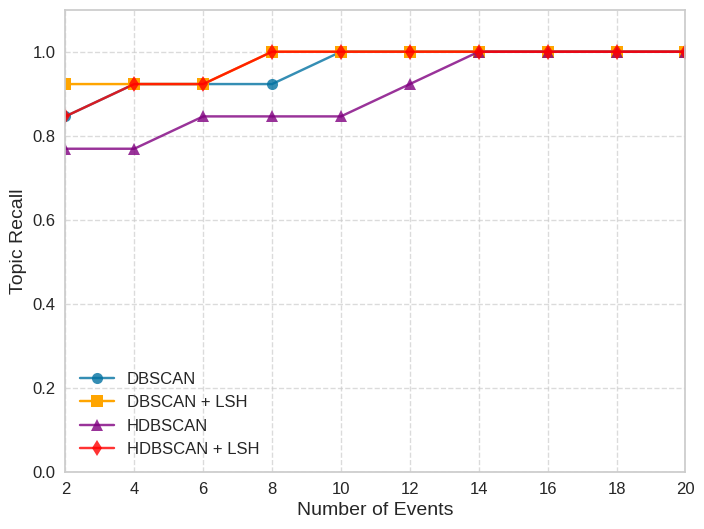

In [ ]:
import matplotlib.pyplot as plt

x_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

DBSCAN_recall = [0.846, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
DBSCAN_recall_filter = [0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
HDBSCAN_recall = [0.769, 0.769, 0.846, 0.846, 0.846, 0.923, 1.0, 1.0, 1.0, 1.0]
HDBSCAN_recall_filter = [0.846, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
kmeans_recall = [0.769, 0.769, 0.846, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
kmeans_recall_filter = [0.846, 0.846, 0.923, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0]


plt.figure(figsize=(8, 6))

plt.plot(x_values, DBSCAN_recall, marker='o', linestyle='-', label='DBSCAN', markersize=8, alpha=0.8)
plt.plot(x_values, DBSCAN_recall_filter, marker='s', linestyle='-', label='DBSCAN + LSH', color='orange', markersize=8, alpha=1)

plt.plot(x_values, HDBSCAN_recall, marker='^', linestyle='-', label='HDBSCAN', color='purple', markersize=8, alpha=0.8)
plt.plot(x_values, HDBSCAN_recall_filter, marker='d', linestyle='-', label='HDBSCAN + LSH', color='red', markersize=8, alpha=0.8)



plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("FACup_DBSCAN_HDBSCAN_LSH_Recall.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


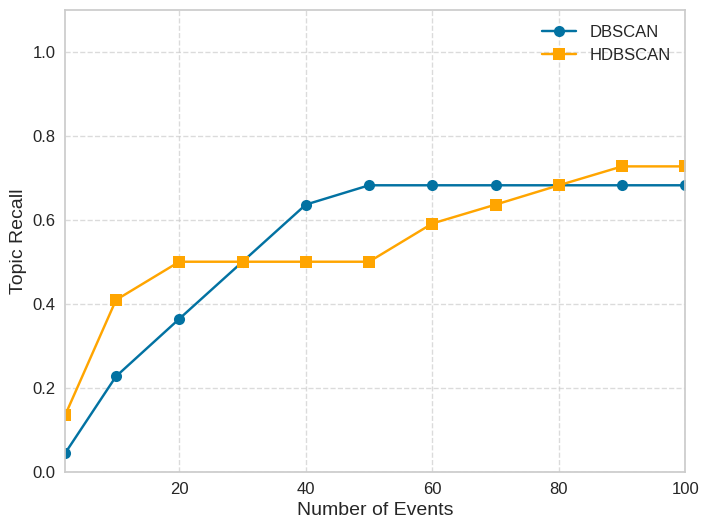

In [ ]:
import matplotlib.pyplot as plt

x_values = [2,10,20,30,40,50,60,70,80,90,100]

DBSCAN_recall = [0.045, 0.227, 0.364, 0.5, 0.636, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682]
# 0.237 || 0.345
HDBSCAN_recall = [0.136, 0.409, 0.5, 0.5, 0.5, 0.5, 0.591, 0.636, 0.682, 0.727, 0.727]
# 0.289 || 0.333
kmeans_recall = [0.0, 0.136, 0.273, 0.364, 0.409, 0.455, 0.455, 0.5, 0.5, 0.5, 0.5]
# 0.217

plt.figure(figsize=(8, 6))

plt.plot(x_values, DBSCAN_recall, marker='o', linestyle='-', label='DBSCAN', markersize=8, alpha=1)
plt.plot(x_values, HDBSCAN_recall, marker='s', linestyle='-', label='HDBSCAN', color='orange', markersize=8, alpha=1)

# plt.plot(x_values, HDBSCAN_recall, marker='^', linestyle='-', label='HDBSCAN', color='purple', markersize=8, alpha=0.8)
# plt.plot(x_values, HDBSCAN_recall_filter, marker='d', linestyle='-', label='HDBSCAN + LSH', color='red', markersize=8, alpha=0.8)



plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("SuperTuesday_DBSCAN_HDBSCAN_Recall.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


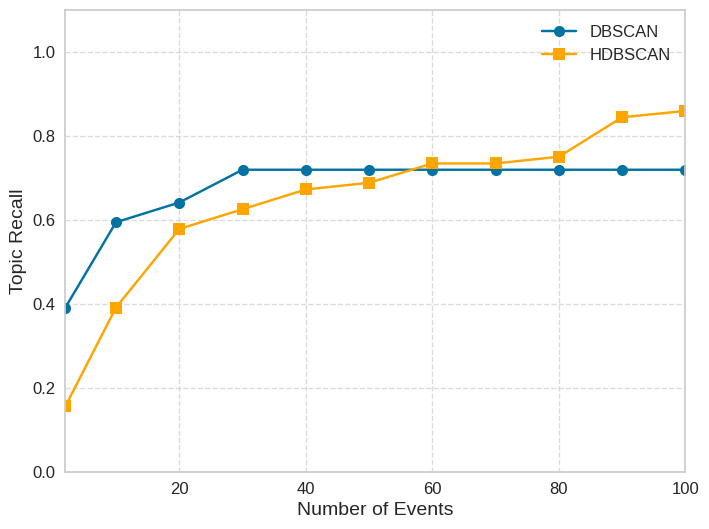

In [ ]:
import matplotlib.pyplot as plt

x_values = [2,10,20,30,40,50,60,70,80,90,100]

DBSCAN_recall = [0.391, 0.594, 0.641, 0.719, 0.719, 0.719, 0.719, 0.719, 0.719, 0.719, 0.719]
# 0.199 || 0.345
HDBSCAN_recall = [0.156, 0.391, 0.578, 0.625, 0.672, 0.688, 0.734, 0.734, 0.75, 0.844, 0.859]
# 0.19 || 0.311
kmeans_recall = [0.031, 0.344, 0.484, 0.641, 0.641, 0.641, 0.641, 0.641, 0.641, 0.641, 0.641]
# 0.191

plt.figure(figsize=(8, 6))

plt.plot(x_values, DBSCAN_recall, marker='o', linestyle='-', label='DBSCAN', markersize=8, alpha=1)
plt.plot(x_values, HDBSCAN_recall, marker='s', linestyle='-', label='HDBSCAN', color='orange', markersize=8, alpha=1)

# plt.plot(x_values, HDBSCAN_recall, marker='^', linestyle='-', label='HDBSCAN', color='purple', markersize=8, alpha=0.8)
# plt.plot(x_values, HDBSCAN_recall_filter, marker='d', linestyle='-', label='HDBSCAN + LSH', color='red', markersize=8, alpha=0.8)



plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("USElections_DBSCAN_HDBSCAN_Recall.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


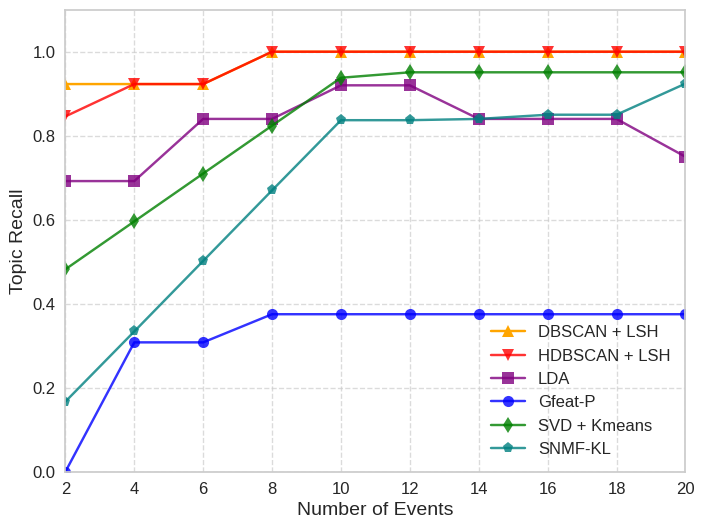

In [ ]:
import matplotlib.pyplot as plt

x_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

DBSCAN_recall_filter = [0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# 0.42
HDBSCAN_recall_filter = [0.846, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# 0.373
lda = [0.692,0.692,0.840,0.840,0.920, 0.920,0.840,0.840,0.840,0.750]
gfeat = [0,0.308,0.308,0.375,0.375,0.375,0.375,0.375,0.375,0.375]
svdKmeans = [0.482,0.596,0.710,0.824,0.938,0.951,0.951,0.951,0.951,0.951]
snmf = [0.167, 0.334, 0.502, 0.670, 0.837, 0.837, 0.840, 0.850, 0.850, 0.924]


plt.figure(figsize=(8, 6))


plt.plot(x_values, DBSCAN_recall_filter, marker='^', linestyle='-', label='DBSCAN + LSH', color='orange', markersize=8, alpha=1)
plt.plot(x_values, HDBSCAN_recall_filter, marker='v', linestyle='-', label='HDBSCAN + LSH', color='red', markersize=8, alpha=0.8)
plt.plot(x_values, lda, marker='s', linestyle='-', label='LDA', color='purple', markersize=8, alpha=0.8)

plt.plot(x_values, gfeat, marker='o', linestyle='-', label='Gfeat-P', color='blue', markersize=8, alpha=0.8)
plt.plot(x_values, svdKmeans, marker='d', linestyle='-', label='SVD + Kmeans', color='green', markersize=8, alpha=0.8)
plt.plot(x_values, snmf, marker='p', linestyle='-', label='SNMF-KL', color='Teal', markersize=8, alpha=0.8)



plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("FACup_Methods_Comparison.png", dpi=300)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


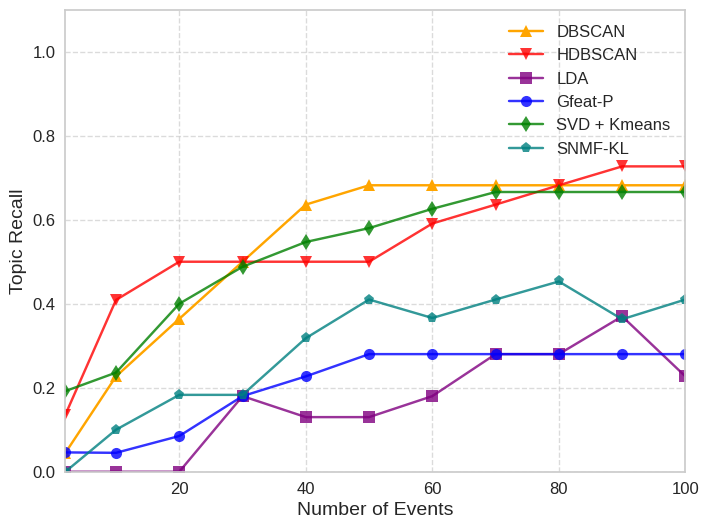

In [ ]:
import matplotlib.pyplot as plt

x_values = [2,10,20,30,40,50,60,70,80,90,100]

DBSCAN_recall = [0.045, 0.227, 0.364, 0.5, 0.636, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682]
# 0.237 || 0.345
HDBSCAN_recall = [0.136, 0.409, 0.5, 0.5, 0.5, 0.5, 0.591, 0.636, 0.682, 0.727, 0.727]
# 0.289 || 0.333

lda = [0.000, 0.000, 0.000, 0.180, 0.130, 0.130, 0.180, 0.280, 0.280, 0.370, 0.227]

gfeat = [0.046, 0.045, 0.085, 0.180, 0.227, 0.280, 0.280, 0.280, 0.280, 0.280, 0.280]

svdKmeans =  [0.192, 0.236, 0.400, 0.488, 0.547, 0.580, 0.626, 0.666, 0.666, 0.666, 0.666]
snmf =  [0.000, 0.100, 0.183, 0.183, 0.318, 0.410, 0.366, 0.410, 0.453, 0.363, 0.410]


plt.figure(figsize=(8, 6))


plt.plot(x_values, DBSCAN_recall, marker='^', linestyle='-', label='DBSCAN', color='orange', markersize=8, alpha=1)
plt.plot(x_values, HDBSCAN_recall, marker='v', linestyle='-', label='HDBSCAN', color='red', markersize=8, alpha=0.8)
plt.plot(x_values, lda, marker='s', linestyle='-', label='LDA', color='purple', markersize=8, alpha=0.8)

plt.plot(x_values, gfeat, marker='o', linestyle='-', label='Gfeat-P', color='blue', markersize=8, alpha=0.8)
plt.plot(x_values, svdKmeans, marker='d', linestyle='-', label='SVD + Kmeans', color='green', markersize=8, alpha=0.8)
plt.plot(x_values, snmf, marker='p', linestyle='-', label='SNMF-KL', color='Teal', markersize=8, alpha=0.8)



plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("SuperTuesday_Methods_Comparison.png", dpi=300)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


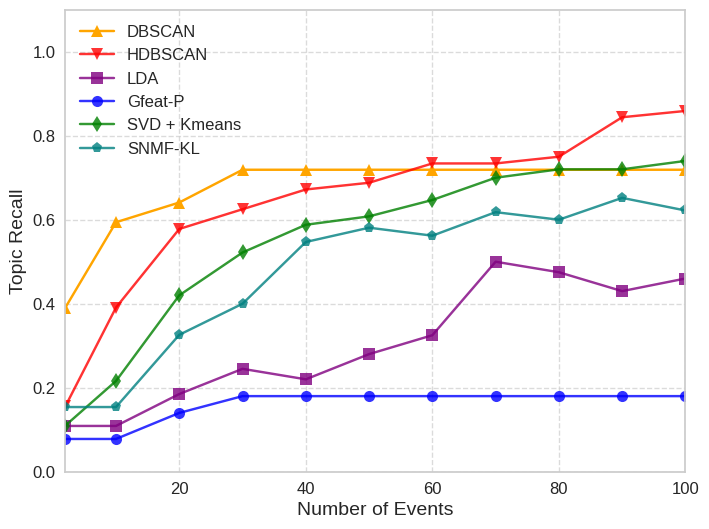

In [ ]:
import matplotlib.pyplot as plt

x_values = [2,10,20,30,40,50,60,70,80,90,100]

DBSCAN_recall = [0.391, 0.594, 0.641, 0.719, 0.719, 0.719, 0.719, 0.719, 0.719, 0.719, 0.719]
# 0.199 || 0.345
HDBSCAN_recall = [0.156, 0.391, 0.578, 0.625, 0.672, 0.688, 0.734, 0.734, 0.75, 0.844, 0.859]
# 0.19 || 0.311

lda = [0.109, 0.109, 0.185, 0.245, 0.220, 0.280, 0.325, 0.500, 0.475, 0.430, 0.460]

gfeat = [0.078, 0.078, 0.140, 0.180, 0.180, 0.180, 0.180, 0.180, 0.180, 0.180, 0.180]

svdKmeans =  [0.110, 0.216, 0.420, 0.522, 0.588, 0.608, 0.647, 0.700, 0.720, 0.720, 0.740]
snmf = [0.154, 0.154, 0.326, 0.400, 0.547, 0.581, 0.562, 0.618, 0.600, 0.652, 0.622]


plt.figure(figsize=(8, 6))


plt.plot(x_values, DBSCAN_recall, marker='^', linestyle='-', label='DBSCAN', color='orange', markersize=8, alpha=1)
plt.plot(x_values, HDBSCAN_recall, marker='v', linestyle='-', label='HDBSCAN', color='red', markersize=8, alpha=0.8)
plt.plot(x_values, lda, marker='s', linestyle='-', label='LDA', color='purple', markersize=8, alpha=0.8)

plt.plot(x_values, gfeat, marker='o', linestyle='-', label='Gfeat-P', color='blue', markersize=8, alpha=0.8)
plt.plot(x_values, svdKmeans, marker='d', linestyle='-', label='SVD + Kmeans', color='green', markersize=8, alpha=0.8)
plt.plot(x_values, snmf, marker='p', linestyle='-', label='SNMF-KL', color='Teal', markersize=8, alpha=0.8)



plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("USElections_Methods_Comparison.png", dpi=300)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


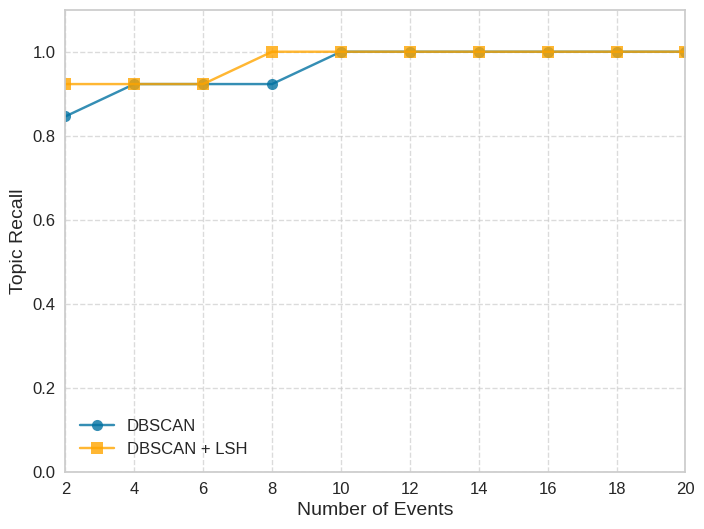

In [ ]:

x_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
DBSCAN_recall = [0.846, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
DBSCAN_recall_filter = [0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

plt.figure(figsize=(8, 6))

plt.plot(x_values, DBSCAN_recall, marker='o', linestyle='-', label='DBSCAN', markersize=8, alpha =0.8)

plt.plot(x_values, DBSCAN_recall_filter, marker='s', linestyle='-', label='DBSCAN + LSH', color='orange', markersize=8 ,alpha=0.8)

plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("FACup_DBSCAN_LSH_Recall.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


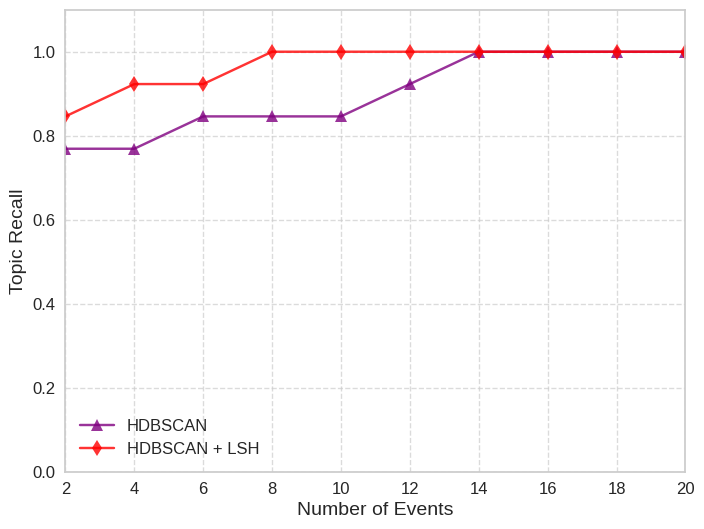

In [ ]:

x_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
HDBSCAN_recall = [0.769, 0.769, 0.846, 0.846, 0.846, 0.923, 1.0, 1.0, 1.0, 1.0]
HDBSCAN_recall_filter = [0.846, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

plt.figure(figsize=(8, 6))

plt.plot(x_values, HDBSCAN_recall, marker='^', linestyle='-', label='HDBSCAN', color='Purple', markersize=8,alpha=0.8)

plt.plot(x_values, HDBSCAN_recall_filter, marker='d', linestyle='-', label='HDBSCAN + LSH', color='red', markersize=8,alpha=0.8)

plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("FACup_HDBSCAN_LSH_Recall.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


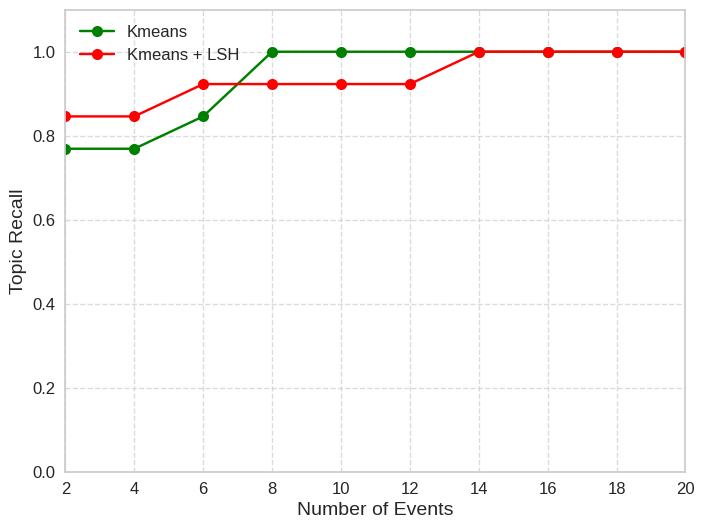

In [ ]:

x_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
kmeans_recall = [0.769, 0.769, 0.846, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
kmeans_recall_filter = [0.846, 0.846, 0.923, 0.923, 0.923, 0.923, 1.0, 1.0, 1.0, 1.0]

plt.figure(figsize=(8, 6))

plt.plot(x_values, kmeans_recall, marker='o', linestyle='-', label='Kmeans', color='Green', markersize=8)

plt.plot(x_values, kmeans_recall_filter, marker='o', linestyle='-', label='Kmeans + LSH', color='red', markersize=8)

plt.ylim(0, 1.1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.xlim(x_values[0], x_values[-1])
plt.xticks(fontsize=12)
plt.xlabel('Number of Events', fontsize=14)
plt.ylabel('Topic Recall', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12)

plt.savefig("FACup_Kmeans_LSH_Recall.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['0.385', '0.769', '0.846', '0.846', '0.923', '0.923', '0.923', '0.923', '0.923', '0.923']


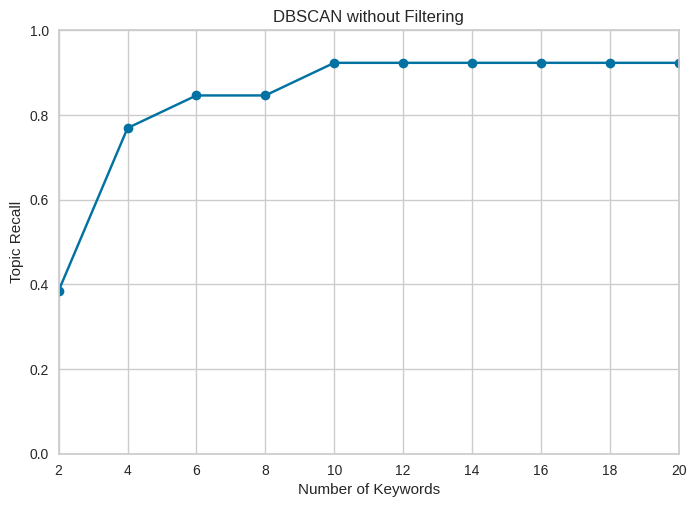

In [ ]:
x_values = [2,4,6,8,10,12,14,16,18,20]
# x_values = [2,10,20,30,40,50,60,70,80,90,100]
print(DBSCAN_recall)
trial = [float(value) for value in DBSCAN_recall]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xticks(range(2, 21, 2))
plt.xlabel('Number of Keywords')
plt.ylabel('Topic Recall')
plt.title('DBSCAN without Filtering')
plt.grid(True)
plt.savefig("DBSCAN without Filtering Topic Recall.png")

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


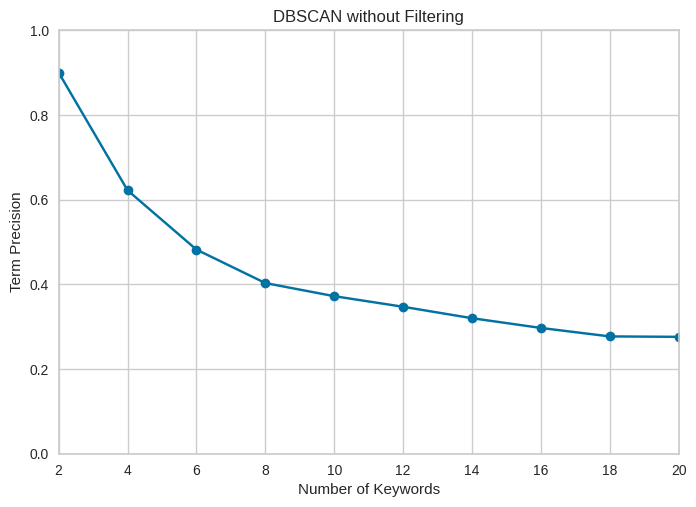

In [ ]:
trial = [float(value) for value in DBSCAN_precision]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Term Precision')
plt.title('DBSCAN without Filtering')
plt.savefig(f"DBSCAN without Filtering Term Precision.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


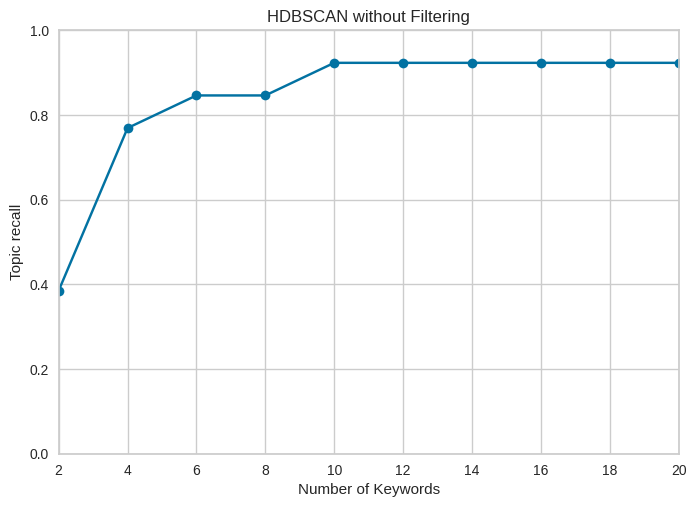

In [ ]:
trial = [float(value) for value in HDBSCAN_recall]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
# plt.xticks(range(2, 21, 2))
plt.xlabel('Number of Keywords')
plt.ylabel('Topic recall')
plt.title('HDBSCAN without Filtering')
plt.savefig(f"HDBSCAN without Filtering Topic recall.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


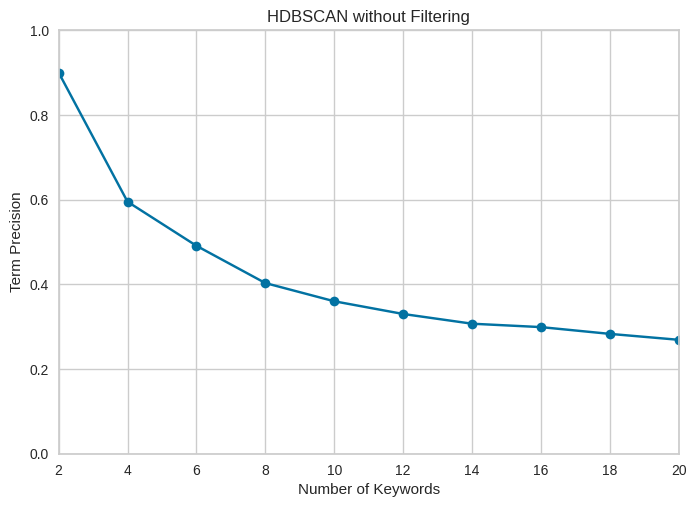

In [ ]:
trial = [float(value) for value in HDBSCAN_precision]

plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Term Precision')
plt.title('HDBSCAN without Filtering')
plt.savefig(f"HDBSCAN without Filtering Term Precision.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


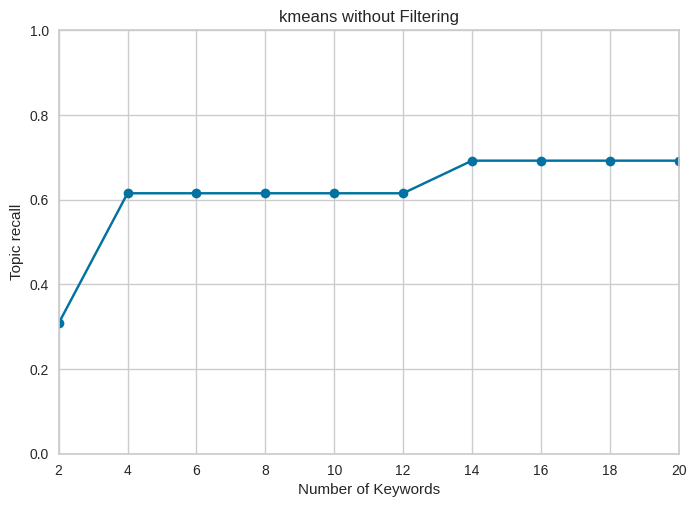

In [ ]:
trial = [float(value) for value in kmeans_recall]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
# plt.xticks(range(2, 21, 2))
plt.xlabel('Number of Keywords')
plt.ylabel('Topic recall')
plt.title('kmeans without Filtering')
plt.savefig(f"kmeans without Filtering Topic recall.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


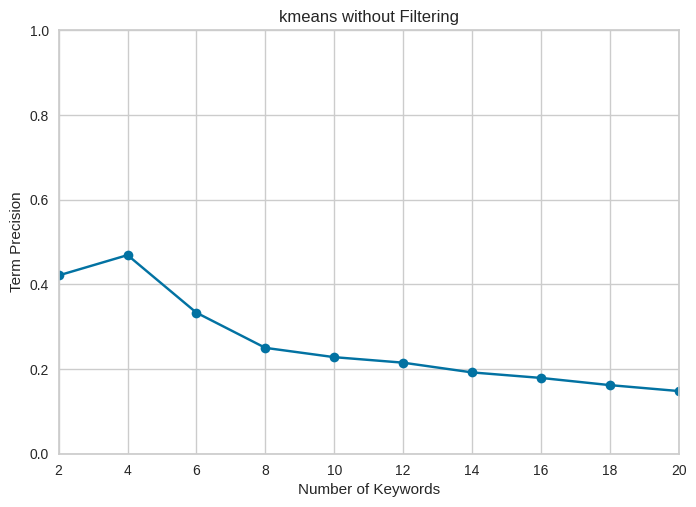

In [ ]:
trial = [float(value) for value in kmeans_precision]

plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Term Precision')
plt.title('kmeans without Filtering')
plt.savefig(f"kmeans without Filtering Term Precision.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


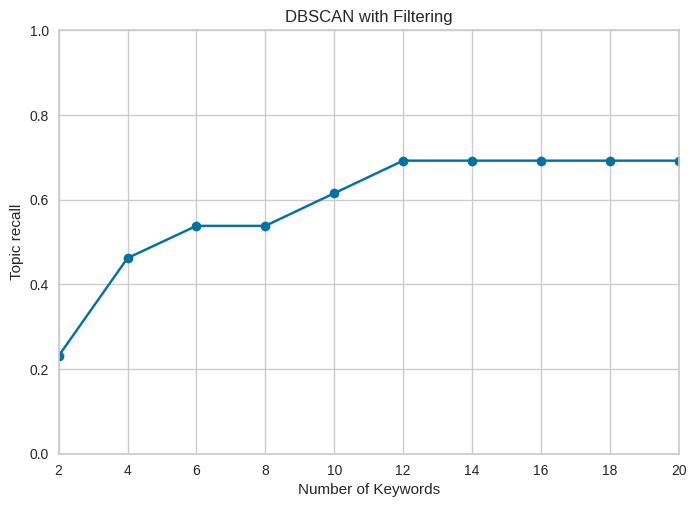

In [ ]:
x_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
trial = [float(value) for value in DBSCAN_recall_filter]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Topic recall')
plt.title('DBSCAN with Filtering')
plt.savefig(f"DBSCAN with Filtering Topic recall.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


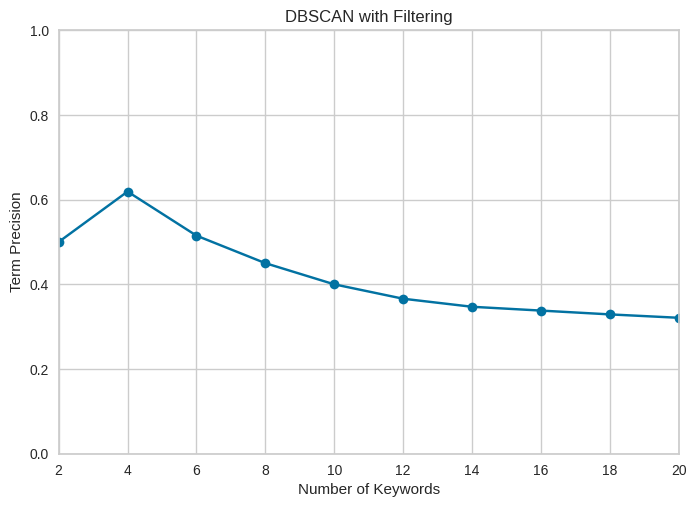

In [ ]:
trial = [float(value) for value in DBSCAN_precision_filter]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Term Precision')
plt.title('DBSCAN with Filtering')
plt.savefig(f"DBSCAN with Filtering Term Precision.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


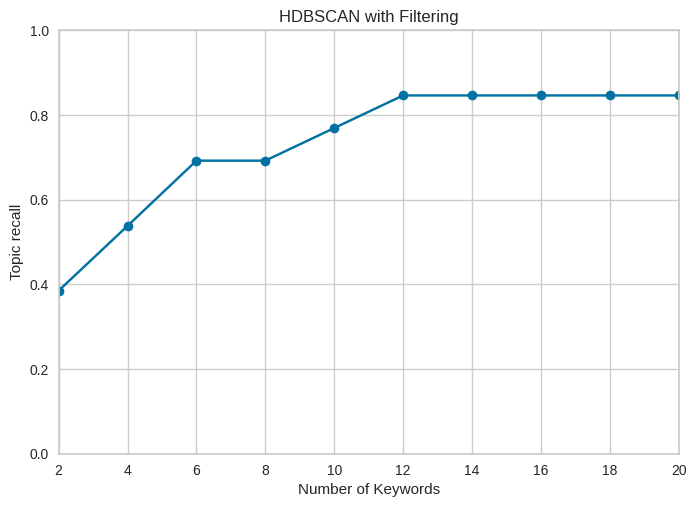

In [ ]:
trial = [float(value) for value in HDBSCAN_recall_filter]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Topic recall')
plt.title('HDBSCAN with Filtering')
plt.savefig(f"HDBSCAN with Filtering Topic recall.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


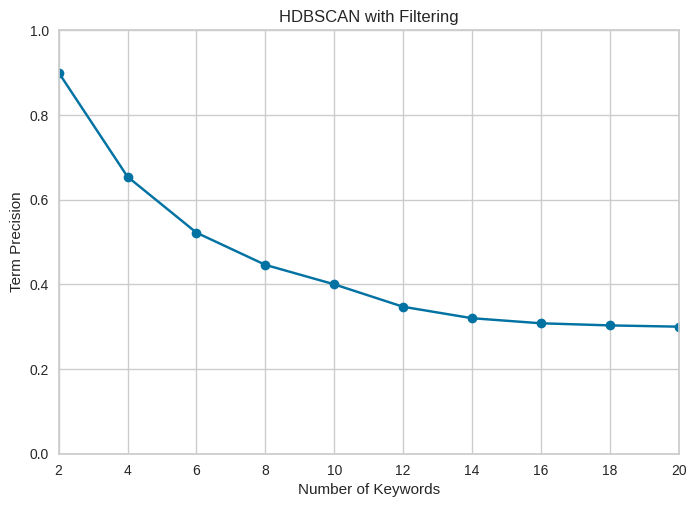

In [ ]:
trial = [float(value) for value in HDBSCAN_precision_filter]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Term Precision')
plt.title('HDBSCAN with Filtering')
plt.savefig(f"HDBSCAN with Filtering Term Precision.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


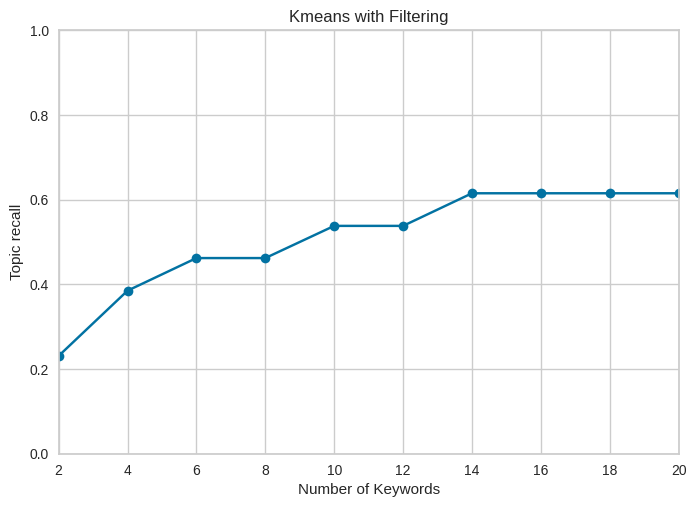

In [ ]:
trial = [float(value) for value in kmeans_recall_filter]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Topic recall')
plt.title('Kmeans with Filtering')
plt.savefig(f"Kmeans with Filtering Topic recall.png")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


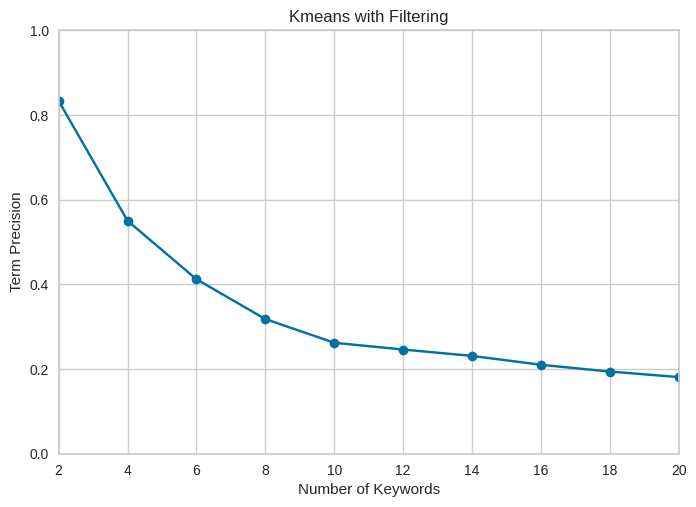

In [ ]:
trial = [float(value) for value in kmeans_precision_filter]
plt.plot(x_values, trial, marker='o', linestyle='-')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(2, 20)
plt.xlabel('Number of Keywords')
plt.ylabel('Term Precision')
plt.title('Kmeans with Filtering')
plt.savefig(f"Kmeans with Filtering Term Precision.png")
plt.show()


## **Zipfile and trials:**

In [ ]:
import re

def extract_values(string):
    # Regular expression pattern to extract the values
    pattern = r'Results @100: \(topic recall \/ term precision \/ term recall\)\s*([\d\.]+) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)\s*([\d\.]+|\bNaN\b) \((\d+)\/(\d+)\)'

    # Extract values using regex
    match = re.search(pattern, string)
    if match:
        # Extract and convert values
        topic_recall = float(match.group(1))
        term_precision = float(match.group(4)) if match.group(4) != 'NaN' else 0
        term_recall = float(match.group(7)) if match.group(7) != 'NaN' else 0

        return [topic_recall, term_precision, term_recall]
    else:
        return None

# Test with example strings
string1 = "Using ground truth files in directory: /kaggle/working/SuperTuesday_groundTruth Using result files in directory: /kaggle/working/super_tuesday/SuperTuesday_result_topics/HDBSCAN Results @100: (topic recall / term precision / term recall) 0.136 (3/22) 0.211 (19/90) 1 (19/19)"
string2 = "Using ground truth files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_ground_truth_topics Using result files in directory: /content/drive/MyDrive/Datasets/Evaluation Dataset/FA Cup/FACup_result_topics/DBSCAN Results @100: (topic recall / term precision / term recall) 0.308 (4/13) 1 (8/8) 0.421 (8/19)"
string3 = "Using ground truth files in directory: /kaggle/working/SuperTuesday_groundTruth Using result files in directory: /kaggle/working/super_tuesday/SuperTuesday_result_topics/DBSCAN Results @100: (topic recall / term precision / term recall) 0 (0/22) NaN (0/0) NaN (0/0)"

print(extract_values(string1))  # Output: [0.136, 0.211, 1]
print(extract_values(string2))  # Output: [0.308, 1, 0.421]
print(extract_values(string3))  # Output: [0.0, 0.0, 0.0]


[0.136, 0.211, 1.0]
[0.308, 1.0, 0.421]
[0.0, 0, 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !zip Evaluation.zip "/content/drive/MyDrive/Datasets/Evaluation Dataset"
import zipfile
import os
def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

folder_to_zip = '/content/drive/MyDrive/Datasets/SuperTuesday_Modified_GroundTruth'
zip_file_path = '/content/drive/MyDrive/Datasets/SuperTuesday_Modified_GroundTruth.zip'

zip_folder(folder_to_zip, zip_file_path)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster Labels:
None


# **Twitter Scraping**

In [ ]:
!pip install ntscraper
from ntscraper import Nitter
import json


In [ ]:
tweets = Nitter().get_tweets("elonmusk", mode='user', number=10)
print(tweets)

Testing instances: 100%|██████████| 77/77 [01:25<00:00,  1.11s/it]
INFO:root:No instance specified, using random instance https://nitter.privacydev.net
INFO:root:Current stats for elonmusk: 10 tweets, 0 threads...


{'tweets': [{'link': 'https://twitter.com/elonmusk/status/1778881361249800203#m', 'text': 'Supervised full self-driving now $99/month', 'user': {'name': 'Elon Musk', 'username': '@elonmusk', 'profile_id': '1780044485541699584', 'avatar': 'https://pbs.twimg.com/profile_images/1780044485541699584/p78MCn3B_bigger.jpg'}, 'date': 'Apr 12, 2024 · 8:22 PM UTC', 'is-retweet': False, 'is-pinned': True, 'external-link': '', 'replying-to': [], 'quoted-post': {'link': 'https://twitter.com/Tesla/status/1778881172807815178#m', 'text': 'You can now subscribe to FSD (Supervised) for $99/month in the US  ts.la/app   Upgrades > Software Upgrades > Subscribe', 'user': {'name': 'Tesla', 'username': '@Tesla', 'profile_id': '1337607516008501250', 'avatar': 'https://pbs.twimg.com/profile_images/1337607516008501250/6Ggc4S5n_mini.png'}, 'date': 'Apr 12, 2024 · 8:21 PM UTC', 'pictures': [], 'videos': [], 'gifs': []}, 'stats': {'comments': 11426, 'retweets': 7874, 'quotes': 1071, 'likes': 63867}, 'pictures': [],

In [ ]:
with open("elon.json","w") as file:
    json.dump(tweets,file, indent = 4)

In [ ]:
# !pip install ntscraper
# from ntscraper import Nitter
# import json
# nitterV = Nitter()
def get_tweets_from_ids(input_file, output_file, mode='user', number=10):
    with open(input_file, 'r', encoding='latin-1') as f:
        tweet_ids = [line.strip() for line in f]

    tweets = []

    for tweet_id in tweet_ids:
        tweet = nitterV.get_tweets(tweet_id)
        tweets.append(tweet)
        print(tweet)

    with open(output_file, 'w') as f:
        json.dump(tweets, f, indent=4)


In [ ]:
input_file = 'drive/MyDrive/Datasets/FA Cup/FACup_tweets/5_5_2012_14_0.json'
output_file = 'retrieved_tweets.json'
get_tweets_from_ids(input_file, output_file)

In [ ]:
tweets = nitterV.get_tweets("198774047390183425")
print(tweets)

INFO:root:No instance specified, using random instance https://nitter.esmailelbob.xyz


{'tweets': [], 'threads': []}


In [ ]:
import requests
from bs4 import BeautifulSoup
def extract_tweet_info(tweet_id):
    tweet_url = f"https://twitter.com/anyuser/status/{tweet_id}"

    try:
        data = requests.get(tweet_url ,headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36"})

        soup = BeautifulSoup(data.content, 'html.parser')

        tweet_text_elem = soup.find("div", {"data-testid": "tweet"})
        tweets = soup.find_all('div' , {'class': 'content'})
        print(soup.find_all("div"))
        if tweet_text_elem:
            tweet_text = tweet_text_elem.text.strip()
        else:
            tweet_text = "Tweet content not found (possibly deleted)."

        tweet_time_elem = soup.find("time")
        if tweet_time_elem:
            tweet_time = tweet_time_elem["datetime"]
        else:
            tweet_time = "Tweet time not found."

        sender_name_elem = soup.find("div", {"data-testid": "tweet"})
        if sender_name_elem:
            sender_name = sender_name_elem["data-name"]
        else:
            sender_name = "Sender name not found."

        return {
            "tweet_text": tweet_text,
            "tweet_time": tweet_time,
            "sender_name": sender_name
        }
    except requests.exceptions.HTTPError as e:
        print("HTTP Error occurred:", e)
        return None
    except Exception as e:
        print("Error occurred:", e)
        return None


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import time

def extract_tweet_info(tweet_id):
    # Set up Chrome options
    options = Options()
    options.headless = True
    options.add_argument("--window-size=1920,1200")

    chromedriver_path = '/path/to/chromedriver'

    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service, options=options)

    try:
        tweet_url = f"https://twitter.com/i/web/status/{tweet_id}"

        driver.get(tweet_url)

        time.sleep(5)

        tweet_text = driver.find_element(By.CSS_SELECTOR, "div[data-testid='tweet']").text
        tweet_time = driver.find_element(By.CSS_SELECTOR, "time").get_attribute("datetime")
        sender_name = driver.find_element(By.CSS_SELECTOR, "div[data-testid='tweet']").get_attribute("data-name")

        return {
            "tweet_text": tweet_text,
            "tweet_time": tweet_time,
            "sender_name": sender_name
        }
    finally:
        driver.quit()

tweet_id = "1234567890123456789"
tweet_info = extract_tweet_info(tweet_id)

if tweet_info:
    print("Tweet Text:", tweet_info["tweet_text"])
    print("Tweet Time:", tweet_info["tweet_time"])
    print("Sender's Name:", tweet_info["sender_name"])

In [ ]:
extract_tweet_info(1779155286240202854)

# **Load Twitter FA Cup Dataset:**

In [ ]:

with open('drive/MyDrive/Datasets/FA Cup/FACup_tweets/5_5_2012_14_0.json', 'r',encoding='latin-1') as f:
    json_data = f.readlines()

json_objects = [json.loads(obj.strip()) for obj in json_data]
for obj in json_objects:
    obj['user'] = obj['user']['screen_name']
df = pd.DataFrame(json_objects)
df.drop(columns=['id_str'], inplace=True)


In [ ]:
all_json_objects = []

directory = 'drive/MyDrive/Datasets/FA Cup/FACup_tweets/'

for filename in os.listdir(directory):
    if filename.endswith(".json"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='latin-1') as f:
            json_data = f.readlines()
        json_objects = [json.loads(obj.strip()) for obj in json_data]
        for obj in json_objects:
            obj['user'] = obj['user']['screen_name']
        all_json_objects.extend(json_objects)

df = pd.DataFrame(all_json_objects)
df.drop(columns=['id_str'], inplace=True)

df.to_excel('output_excel_file.xlsx', index=False)

In [ ]:
df

id                                               text  \
0       198774296905121794  I'll probably get slaughtered for this... But ...   
1       198774301984423937  Fuck off Chelsea FC, you ain't got no history,...   
2       198774301946683392  #facupfinal Funny !.  How f'n crazy..!  http:/...   
3       198774302353539072  Coverage starts at 3.15. Therefore, only 15 mi...   
4       198774301791502336  2 more hours in singapore for the final and ho...   
...                    ...                                                ...   
300010  198864639755436032              @ToyeCFC we won, who cares bro?? #cfc   
300011  198864640208412673  Well done to the @Staffordshirefa officials to...   
300012  198864640564932609  RT @chelseafc: Chelsea have now won 17 major t...   
300013  198864641110183936  RT @JWTelegraph: #cfc records today: cole most...   
300014  198864641663844352  RT @MAljawisri: \n\n\n\n\n\n??? ??? ?? ??????...   

                            created_at            user  
0       Sat May 05 17:01:00 +0300 2012       lukehirst  
1       Sat May 05 17:01:01 +0300 2012      BBrighouse  
2       Sat May 05 17:01:01 +0300 2012   MartaSuarez14  
3       Sat May 05 17:01:01 +0300 2012   HannahisMusic  
4       Sat May 05 17:01:01 +0300 2012       zahid3109  
...                                ...             ...  
300010  Sat May 05 22:59:59 +0300 2012      kazzyblues  
300011  Sat May 05 22:59:59 +0300 2012       CanaryWes  
300012  Sat May 05 22:59:59 +0300 2012        tarian44  
300013  Sat May 05 22:59:59 +0300 2012          MPres1  
300014  Sat May 05 22:59:59 +0300 2012  FAlSALMohammed  

[300015 rows x 4 columns]

# **Nothing here**

In [ ]:
# Trial

# DBSCAN TRIAL

from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN
from collections import defaultdict

# def get_tweets_vector(tweets_indexes , tfidf_matrix):
#     data = []
#     for i in tweets_indexes:
#         data.append(tfidf_matrix[i])
#     return data

def initial_clustering(initial_group, num_clusters):
    nmf = NMF(n_components=num_clusters)
    W = nmf.fit_transform(initial_group)
    H = nmf.components_

    cluster_assignments = W.argmax(axis=1)

    return cluster_assignments

def incremental_clustering(previous_clusters, new_tweets_tfidf, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    new_cluster_assignments = dbscan.fit_predict(new_tweets_tfidf)

    num_previous_clusters = len(set(previous_clusters))
    new_cluster_assignments[new_cluster_assignments != -1] += num_previous_clusters

    merged_cluster_assignments = np.hstack((previous_clusters, new_cluster_assignments))

    return merged_cluster_assignments

def calculate_tweet_entry_rate(previous_cluster_assignments, current_cluster_assignments, tweet_entry_rate, new_tweet_indexes):
    for cluster in set(current_cluster_assignments):
        new_tweets_entered = [index for index, (prev, current) in enumerate(zip(previous_cluster_assignments, current_cluster_assignments)) if current == cluster and prev != cluster]
        tweet_entry_rate[cluster].extend(new_tweets_entered)
        new_tweet_indexes[cluster].extend(new_tweets_entered)
    return tweet_entry_rate, new_tweet_indexes

def detect_events(tweet_entry_rate, thresholds):
    events = []
    for cluster, rates in tweet_entry_rate.items():
        if len(rates) >= 2:
            rate_change = rates[-1] - rates[-2]
            if rate_change >= thresholds.get(cluster, 0):
                events.append(cluster)
    return events

def get_tweets_related_to_events(events, new_tweet_indexes, ordered_dict_indexes):
    related_tweets = []
    for event_cluster in events:
        cluster_indexes = new_tweet_indexes[event_cluster]
        for index in cluster_indexes:
            tweet_index = ordered_dict_indexes[index]
            related_tweets.append(tweet_index)
    return related_tweets


In [ ]:
num_clusters = 5
eps = 0.5
min_samples = 5
thresholds = {0: 10, 1: 5, 2: 8}


tweet_groups = list(categorized_tweets_indexes.values())

initial_cluster_assignments = initial_clustering(tfidf_matrix[tweet_groups[0]] , num_clusters)

print(initial_cluster_assignments)

tweet_entry_rate = defaultdict(list)

for group_indexes in tweet_groups:
    group_tfidf = tfidf_matrix[group_indexes]
    merged_cluster_assignments = incremental_clustering(initial_cluster_assignments, group_tfidf, eps, min_samples)

    tweet_entry_rate = calculate_tweet_entry_rate(merged_cluster_assignments, tweet_entry_rate)

    initial_cluster_assignments = merged_cluster_assignments

events = detect_events(tweet_entry_rate, thresholds)
print(tweet_entry_rate)
print("Detected events:", events)


[1 4]
-1
Detected events: []
Related tweets: []
